<a href="https://colab.research.google.com/github/PRIMAFF-WAKAMATSU/Productivity/blob/main/%E6%BC%81%E7%B8%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **漁績を使った生産性分析ツール**

In [ ]:
#漁績生産性評価コードを走らせるために必要なパッケージやライブラリのインストール
#DEAなど生産性評価ツール（PyFrontier）のインストール
!pip install Pyfrontier > /dev/null # Hide installation output
from Pyfrontier.frontier_model import EnvelopDEA
#日本語フォントのインストール
!pip install japanize_matplotlib > /dev/null # Hide installation output
#基本的なデータ読み込み、作成ライブラリ
import pandas as pd
import numpy as np
#ノートブックモードでデータを閲覧できるパッケージのインストール
# itablesパッケージをインストール
!pip install itables==2.2.4 -q  > /dev/null # Hide installation output # -q オプションを追加
import itables  # itablesパッケージをインポート
itables.init_notebook_mode(all_interactive=True)  # ノートブックモードを初期化

In [ ]:
# データの読み込み
df = pd.read_excel("/content/gyoseki.xlsx", engine=None)
#船名が入っている場合、船名を取り除く（個人情報保護のため）
#df = df.drop("船名", axis=1)
#df = df.rename(columns={'許可番号': 'ID'})
itables.show(df)

In [ ]:
# 沖底（複数魚種対象漁業）用
#  複数のOutput変数の作成←沖底用：メインの魚種3種類をあげて3つのOutput変数を作る
# それぞれの行について、11列目の変数から50列目までの変数について、一番大きい数値を選び、
#新しい変数output1に入れる。次に2番目に大きい数値を選び、新しい変数output2に入れる。
#次に3番目位に大きい数値を選び、新しい変数output3に入れる。NaNを0に置き換える
df = df.fillna(0)

# 11列目から50列目までのデータを取得
data = df.iloc[:, 10:50]

# 各行について、上位3つの数値を取得
output1 = []
output2 = []
output3 = []

for _, row in data.iterrows():
    # 上位3つの値のインデックスを取得
    top_indices = np.argsort(row)[::-1][:3]  # 降順にソートし、上位3つを取得

    # 上位3つの値をリストに追加
    values = sorted(row, reverse=True)

    # 値が3つ未満の場合、残りの要素を0で埋める
    if len(values) >= 1 :
      output1.append(values[0])
    else :
      output1.append(0)

    if len(values) >= 2:
        output2.append(values[1])
    else:
        output2.append(0)

    if len(values) >= 3:
        output3.append(values[2])
    else:
        output3.append(0)

# 新しい列としてデータフレームに追加
df['output1'] = output1
df['output2'] = output2
df['output3'] = output3

# 結果を表示
itables.show(df)


In [ ]:
# 沖底用
# 年次データに変換し、DEA（CRS)を実行し、各年ごとの各魚種効率性ファイルを保存する
# 兵庫県と鳥取県で重複するIDをユニークにする
# Filter for Hyogo and Tottori prefectures
hyogo_df = df[df['都道府県'] == '兵庫県']
tottori_df = df[df['都道府県'] == '鳥取県']
# Get the maximum ID in Tottori (if any)
max_tottori_id = tottori_df['ID'].max() if not tottori_df.empty else 0

# Adjust Hyogo IDs to avoid overlap
df.loc[df['都道府県'] == '兵庫県', 'ID'] = df.loc[df['都道府県'] == '兵庫県', 'ID'] + max_tottori_id + 1


# Concatenate the dataframes back together
df = pd.concat([tottori_df, hyogo_df])

# IDでCollapseする
columns_to_fill = ['output1', 'output2', 'output3']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

years = [2019, 2020, 2021, 2022, 2023]

# Iterate through years
for year in years:
    # Filter dataframe for the specific year
    df_year = df[df['操業年'] == year]

    # Group by ID and year
    grouped = df_year.groupby(['ID', '操業年'])
    collapsed = grouped.agg({
        **{col: 'sum' for col in df.loc[:, '網数':'計'].columns},
        "都道府県": 'first',
        "漁法コード": 'first',
        '馬力': 'mean',
        'トン数': 'mean',
        "通常従業員数": 'mean',
        'output1': 'sum',  # Add output1 to aggregation
        'output2': 'sum',  # Add output2 to aggregation
        'output3': 'sum'  # Add output3 to aggregation
    })

    # Reorder columns
    net_to_total_cols = collapsed.loc[:, '網数':'output3'].columns.tolist()
    order = ["都道府県", "漁法コード", "馬力", "トン数", "通常従業員数"] + net_to_total_cols
    collapsed = collapsed[order]

    # Fill NaN values
    collapsed['馬力'] = collapsed.groupby('ID')['馬力'].transform(lambda x: x.fillna(x.mean()))
    collapsed['トン数'] = collapsed.groupby('ID')['トン数'].transform(lambda x: x.fillna(x.mean()))
    collapsed['通常従業員数'] = collapsed.groupby('ID')['通常従業員数'].transform(lambda x: x.fillna(x.mean()))

    # Reset index
    collapsed = collapsed.reset_index()
    collapsed = collapsed.dropna()

    # Loop through fish types and calculate efficiency

    dea = EnvelopDEA("CRS", "in")
    dea.fit(
         collapsed[["馬力", "トン数", "網数", "通常従業員数"]].to_numpy(),
         collapsed[['output1', 'output2', 'output3']].to_numpy(),
    )
    result = dea.results

     # Add efficiency to the dataframe
    efficiency_df = pd.DataFrame(result, columns=["score"], index=collapsed.index)
    collapsed = pd.merge(collapsed, efficiency_df, left_index=True, right_index=True)
    collapsed = collapsed.rename(columns={"score": "crs_multiple_output"})

    # Save the results for the current year
    collapsed.to_csv(f"crs_{year}.csv", index=False)


In [ ]:
# 結果を表示
itables.show(collapsed)

In [ ]:
#漁績2019～2023を読み込み、年次データに変換し、DEA（CRS)を実行し、各年ごとの各魚種効率性ファイルを保存する
# データの読み込み, try encoding with shift-jis
#df = pd.read_csv("/content/gyoseki_py.csv", engine='openpyxl')
df = pd.read_excel("/content/gyoseki.xlsx", engine=None)

#兵庫県と鳥取県で重複するIDをユニークにする
# Filter for Hyogo and Tottori prefectures
hyogo_df = df[df['都道府県'] == '兵庫県']
tottori_df = df[df['都道府県'] == '鳥取県']

# Get the maximum ID in Tottori (if any)
max_tottori_id = tottori_df['ID'].max() if not tottori_df.empty else 0

# Adjust Hyogo IDs to avoid overlap
hyogo_df['ID'] = hyogo_df['ID'] + max_tottori_id + 1

# Concatenate the dataframes back together
df = pd.concat([tottori_df, hyogo_df])

# IDでCollapseする
columns_to_fill = ['マダラ', 'スケトウダラ', 'ホッケ', 'ハタハタ', 'サメ・エイ', 'ヒラメ', 'ソウハチ', 'ヒレグロ', 'アカガレイ', 'マガレイ', 'ムシガレイ', 'ヤナギムシガレイ', 'その他のカレイ', 'キアンコウ', 'ニギス', 'エソ類', 'タチウオ', 'マダイ', 'チダイ', 'キダイ', 'アカムツ', 'ハツメ', 'ヤリイカ', 'ホタルイカ', 'スルメイカ', 'イカ類', 'マアジ', 'サバ類', 'カナガシラ', 'タコ類', 'ホッコクアカエビ', 'ザコエビ類', 'クロザコエビ', 'トゲザコエビ', 'その他のエビ類', 'ズワイガニ　カタガニ', 'ズワイガニ　ミズガニ', 'ズワイガニメス', 'ズワイガニF', 'マイワシ', 'ソノタ', '計']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

years = [2019, 2020, 2021, 2022, 2023]

# Iterate through years
for year in years:
    # Filter dataframe for the specific year
    df_year = df[df['操業年'] == year]

    # Group by ID and year
    grouped = df_year.groupby(['ID', '操業年'])
    collapsed = grouped.agg({
        **{col: 'sum' for col in df.loc[:, '網数':'計'].columns},
        "都道府県": 'first',
        "漁法コード": 'first',
        '馬力': 'mean',
        'トン数': 'mean',
        "通常従業員数": 'mean'
    })

    # Reorder columns
    net_to_total_cols = collapsed.loc[:, '網数':'計'].columns.tolist()
    order = ["都道府県", "漁法コード", "馬力", "トン数", "通常従業員数"] + net_to_total_cols
    collapsed = collapsed[order]

    # Fill NaN values
    collapsed['馬力'] = collapsed.groupby('ID')['馬力'].transform(lambda x: x.fillna(x.mean()))
    collapsed['トン数'] = collapsed.groupby('ID')['トン数'].transform(lambda x: x.fillna(x.mean()))
    collapsed['通常従業員数'] = collapsed.groupby('ID')['通常従業員数'].transform(lambda x: x.fillna(x.mean()))

    # Reset index
    collapsed = collapsed.reset_index()
    collapsed = collapsed.dropna()

    # Loop through fish types and calculate efficiency
    for fish_type in columns_to_fill:
        dea = EnvelopDEA("CRS", "in")
        dea.fit(
            collapsed[["馬力", "トン数", "網数", "通常従業員数"]].to_numpy(),
            collapsed[[fish_type]].to_numpy(),
        )
        result = dea.results

        # Add efficiency to the dataframe
        efficiency_df = pd.DataFrame(result, columns=["score"], index=collapsed.index)
        collapsed = pd.merge(collapsed, efficiency_df, left_index=True, right_index=True)
        collapsed = collapsed.rename(columns={"score": f"crs_{fish_type}"})

    # Save the results for the current year
    collapsed.to_csv(f"crs_{year}.csv", index=False)

<ipython-input-17-449d84dac185>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyogo_df['ID'] = hyogo_df['ID'] + max_tottori_id + 1


<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


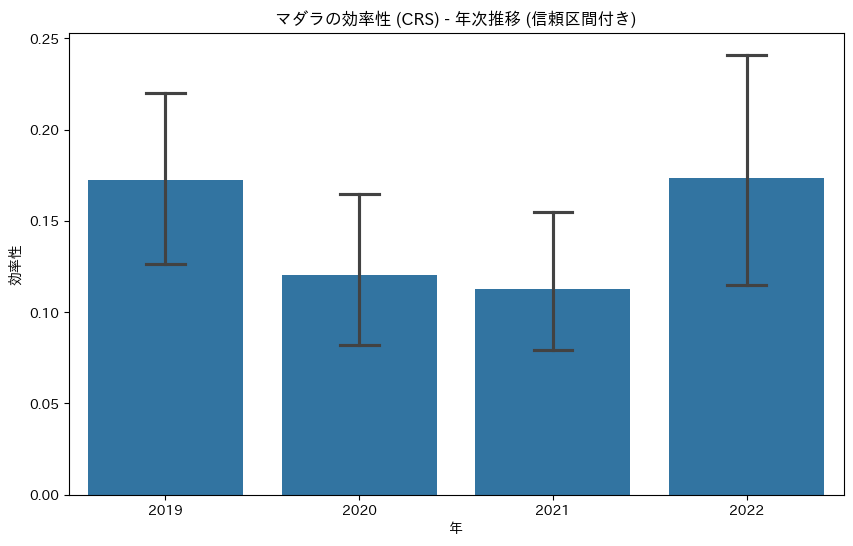

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


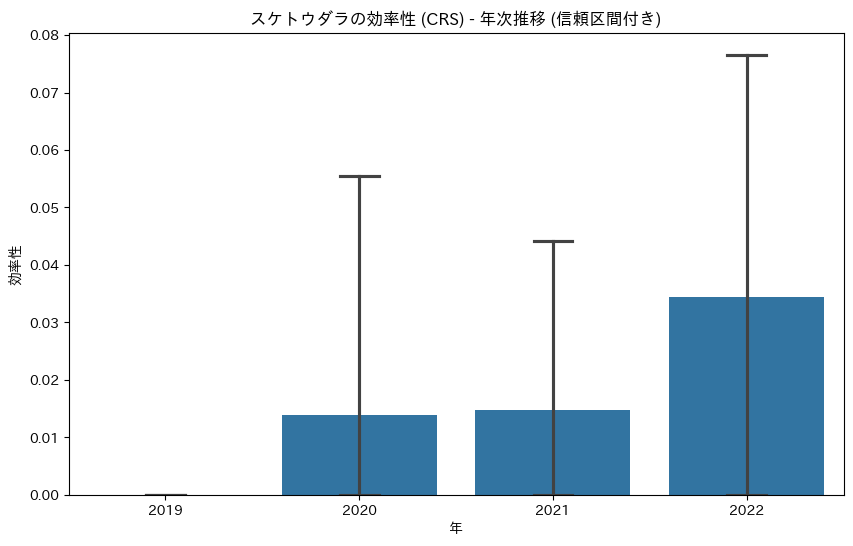

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


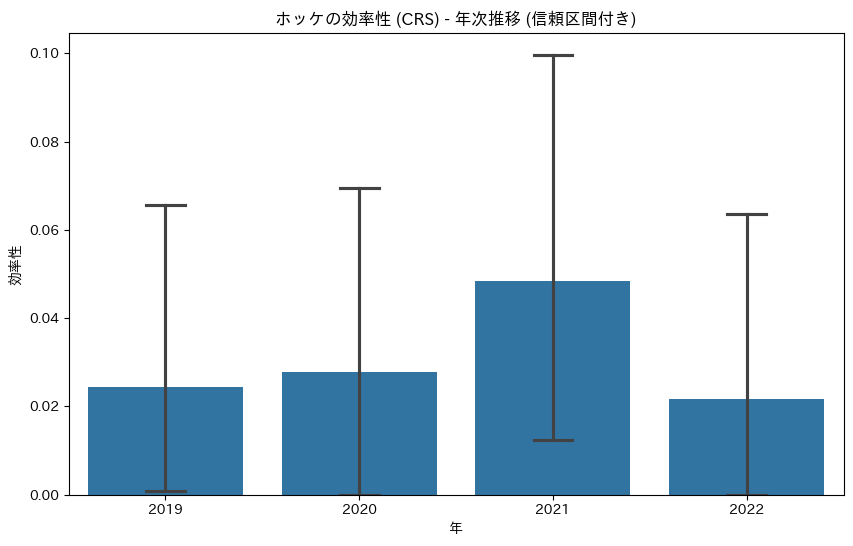

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


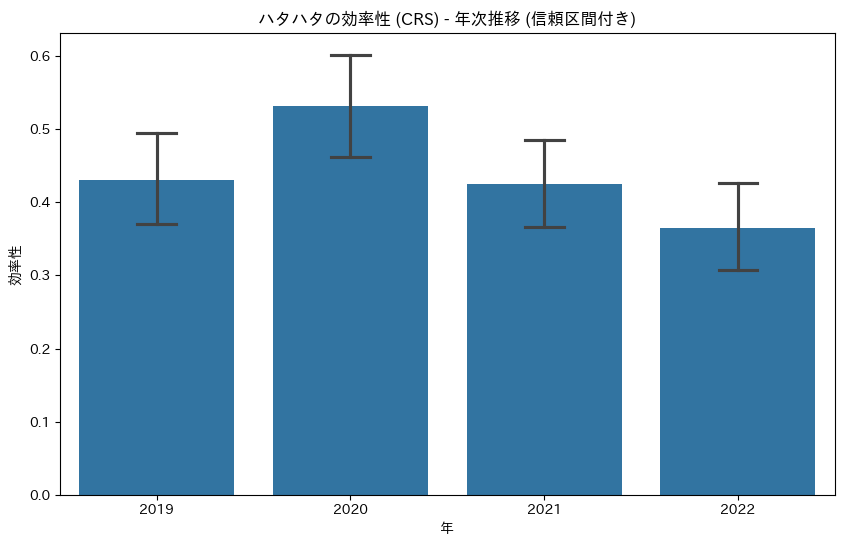

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


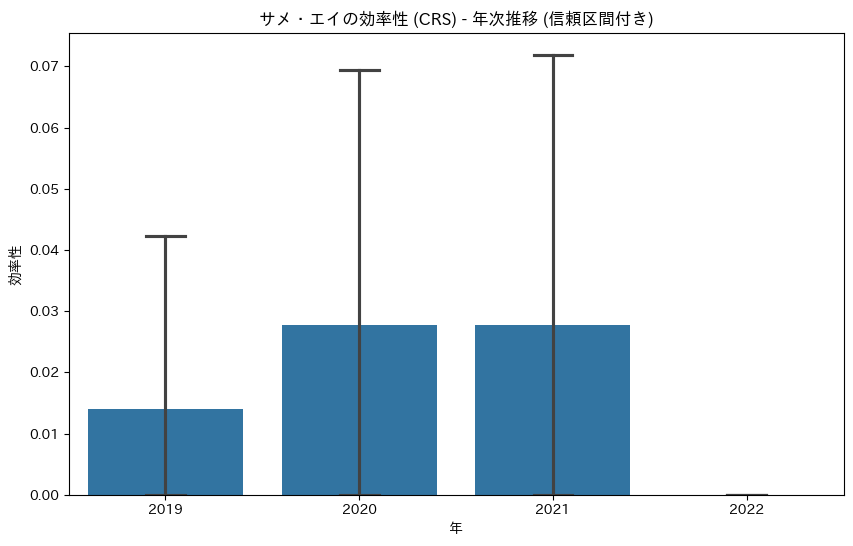

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


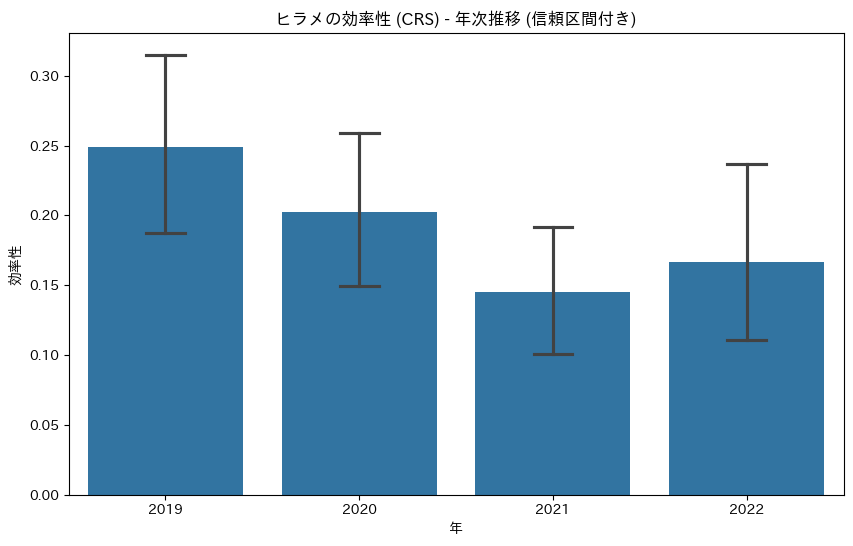

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


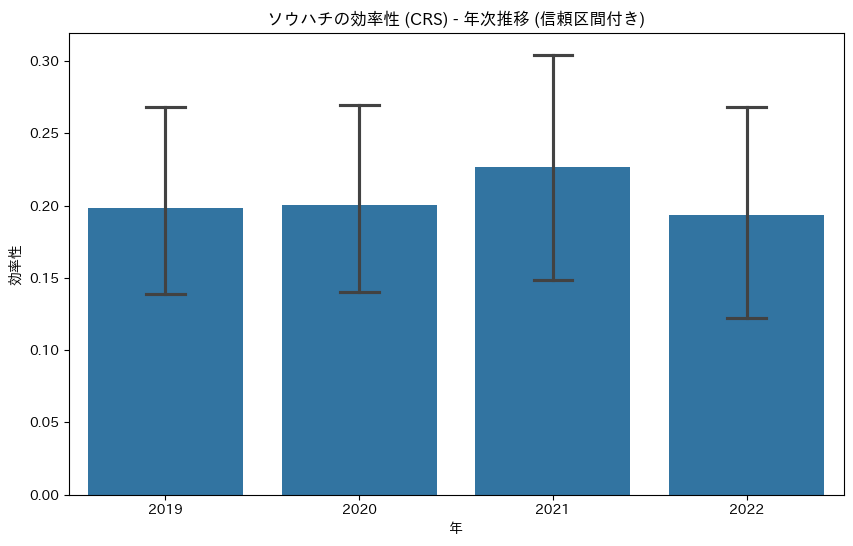

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


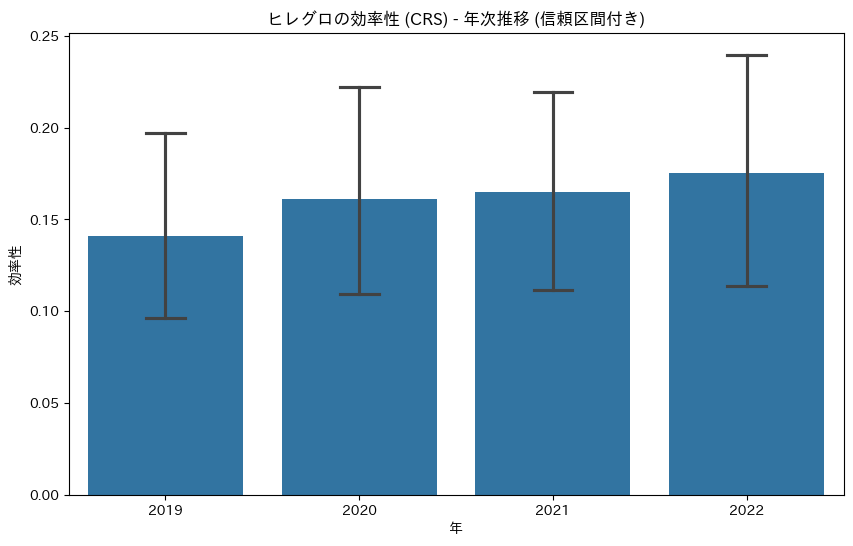

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


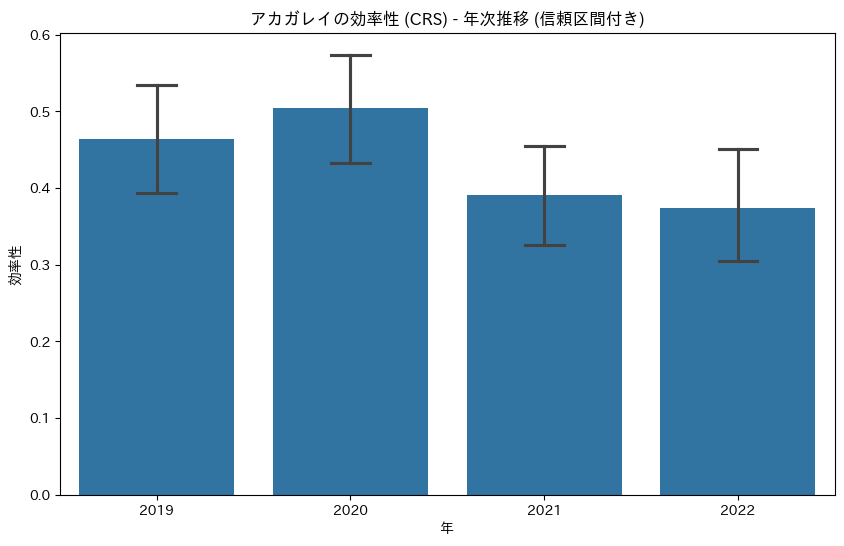

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


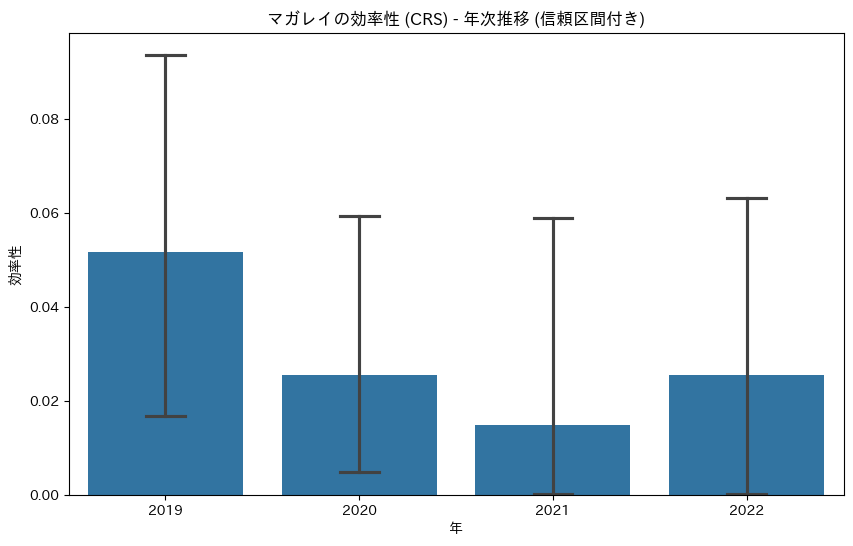

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


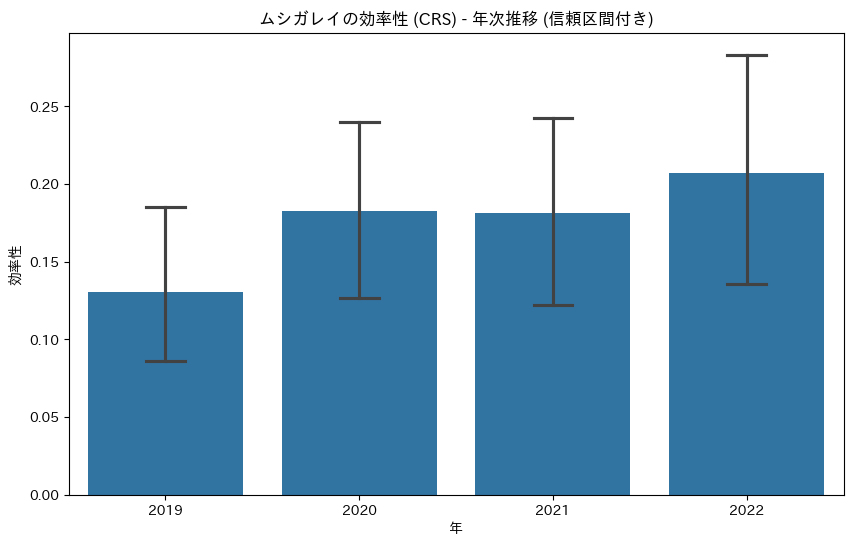

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


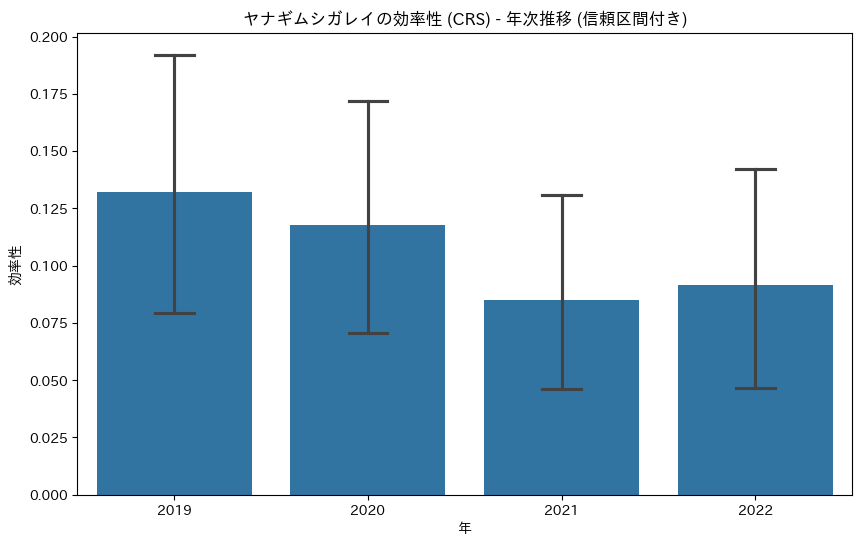

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


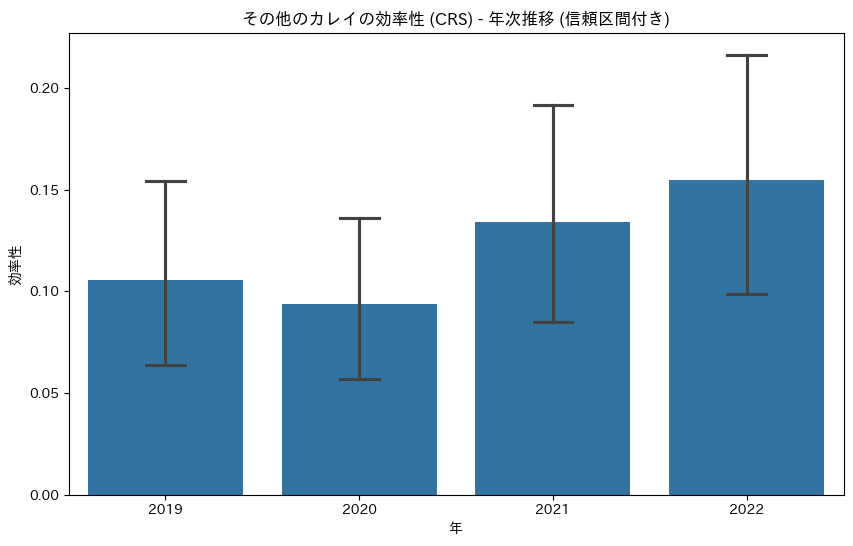

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


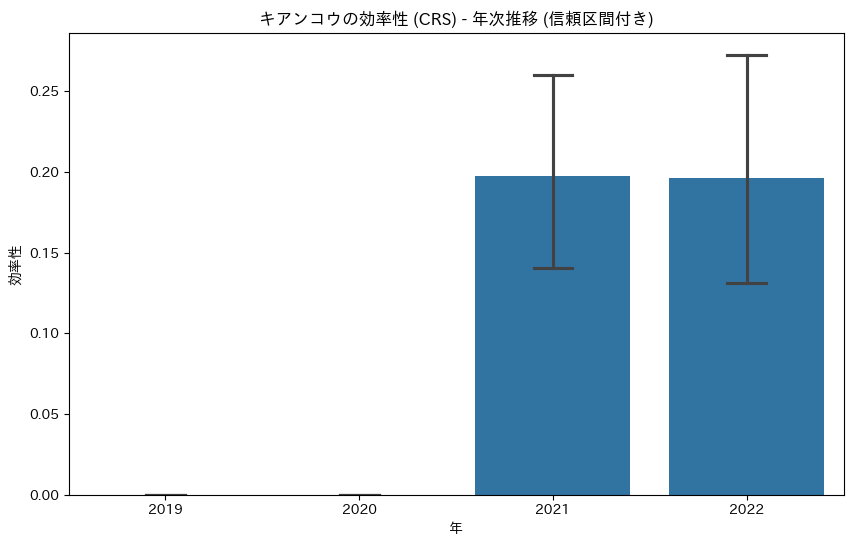

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


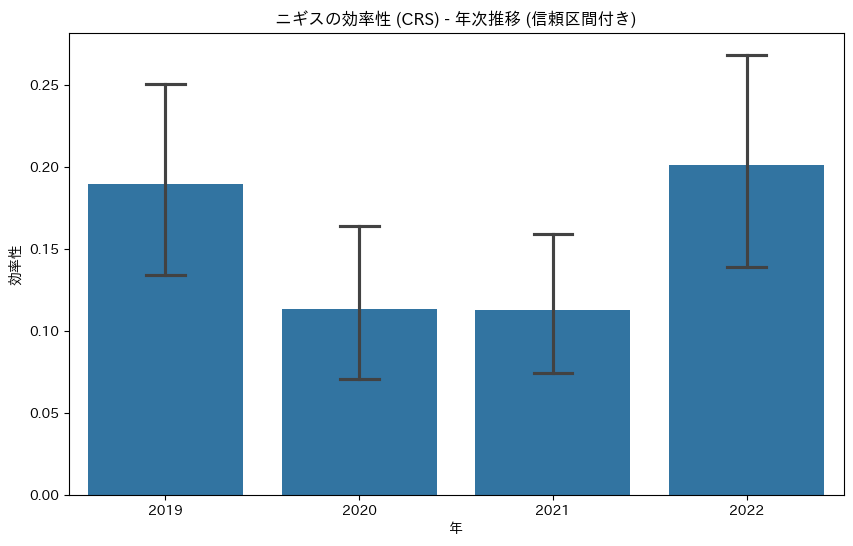

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


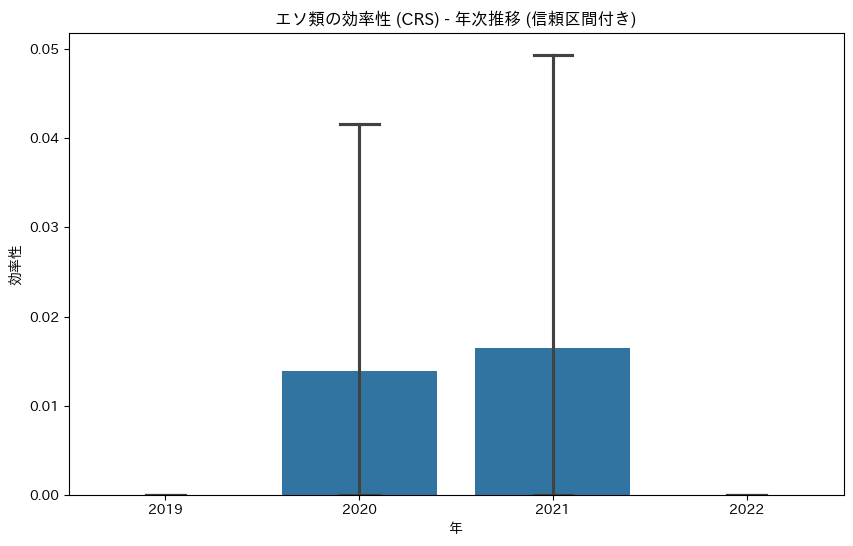

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


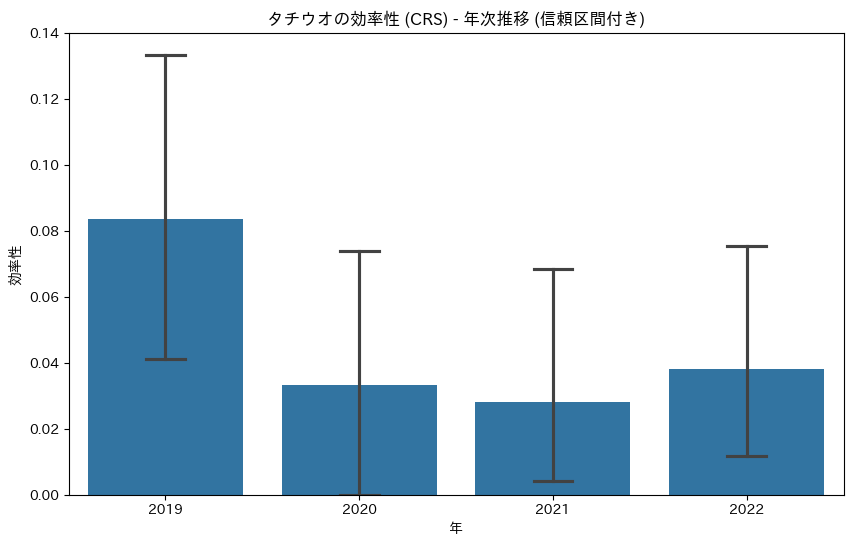

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


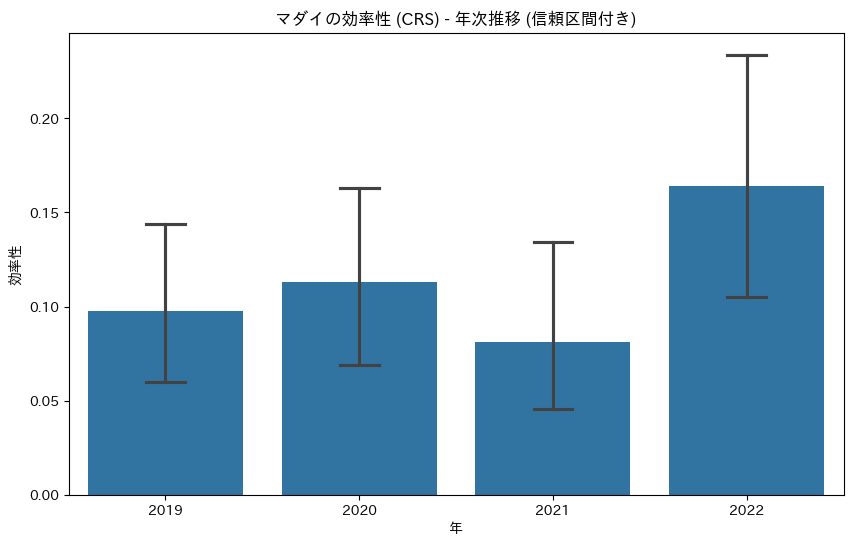

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


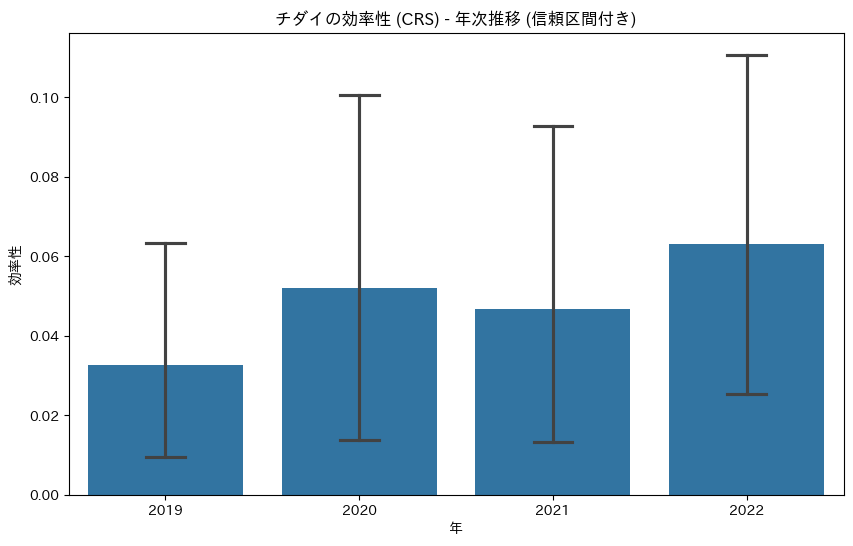

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


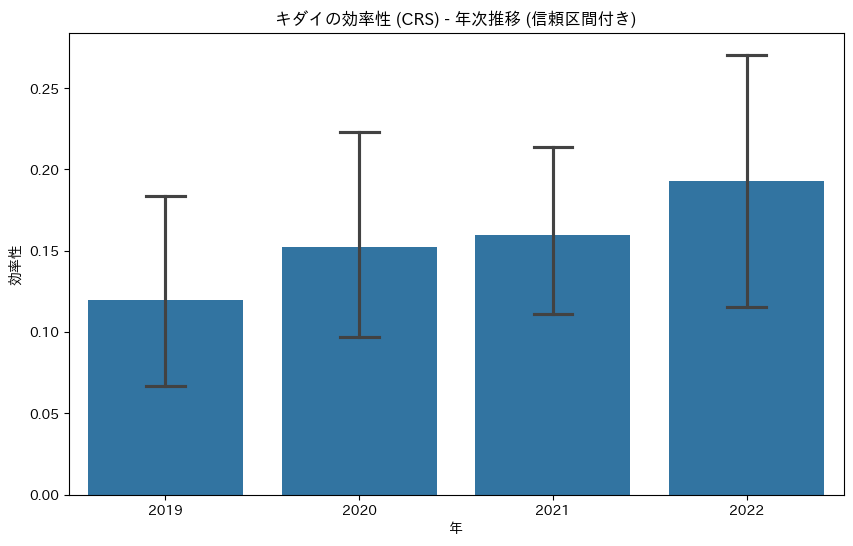

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


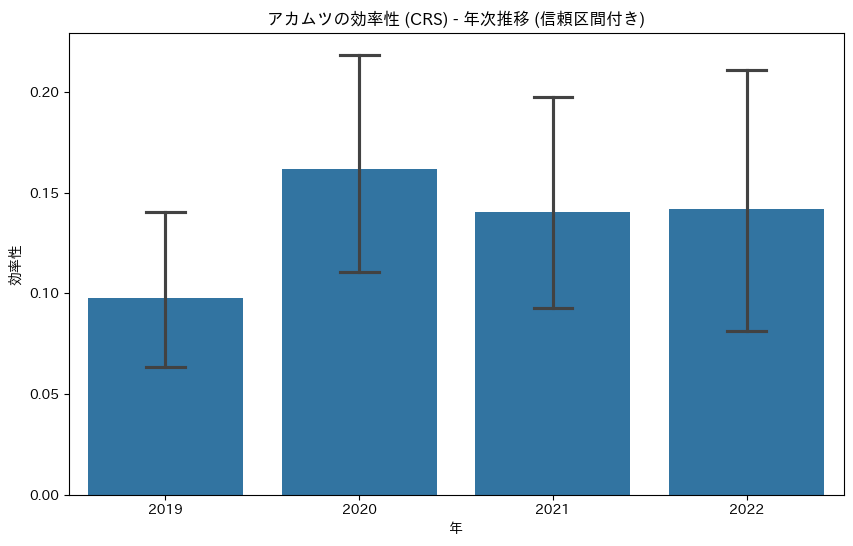

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


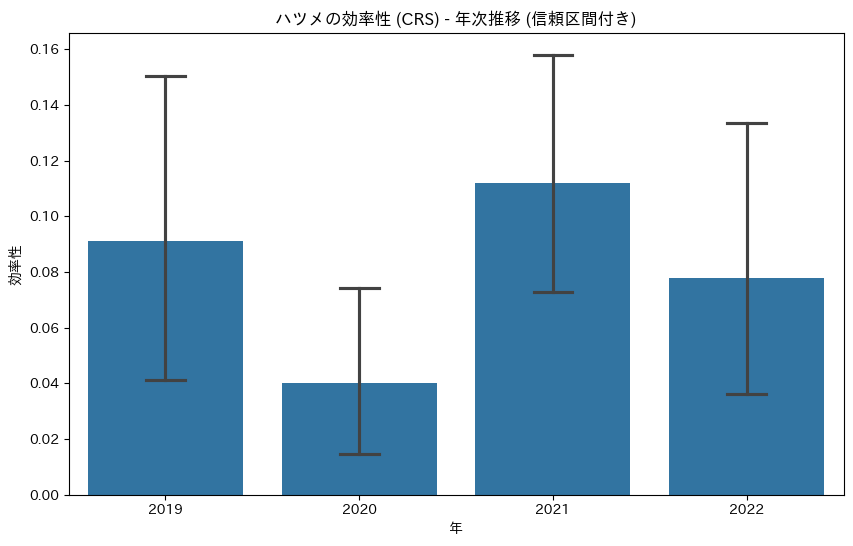

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


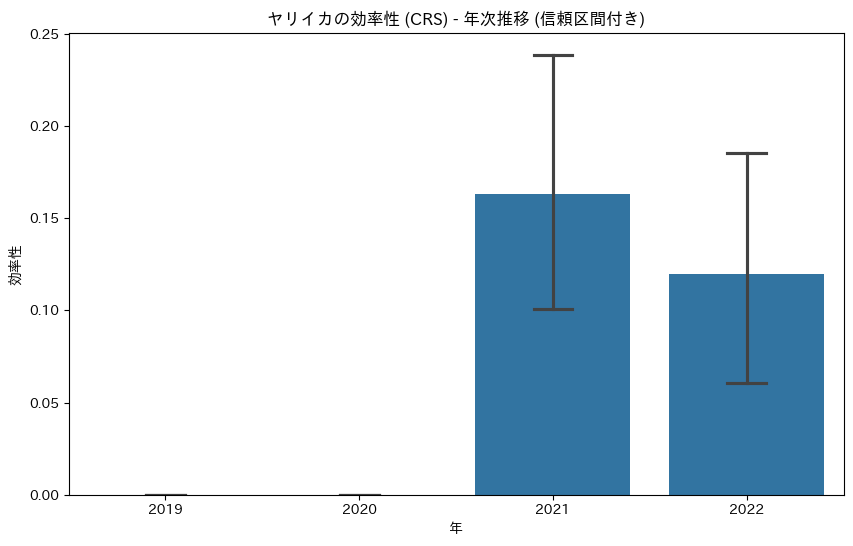

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


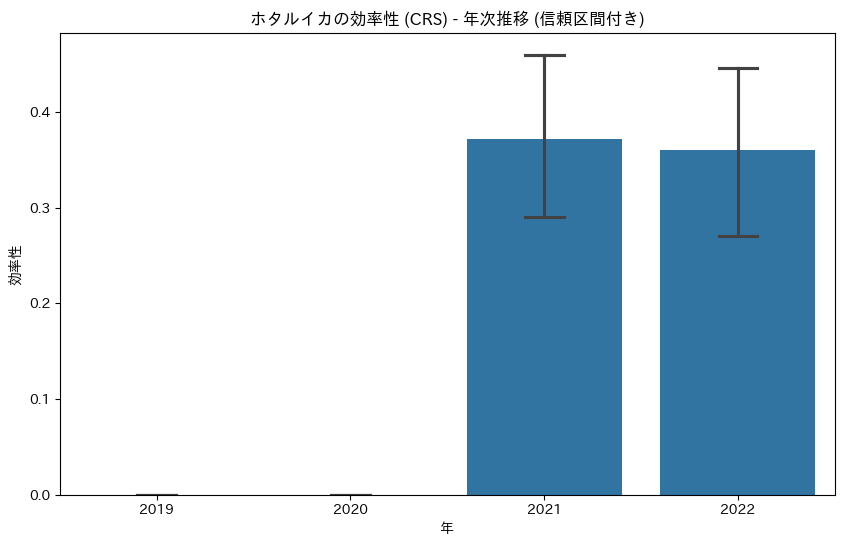

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


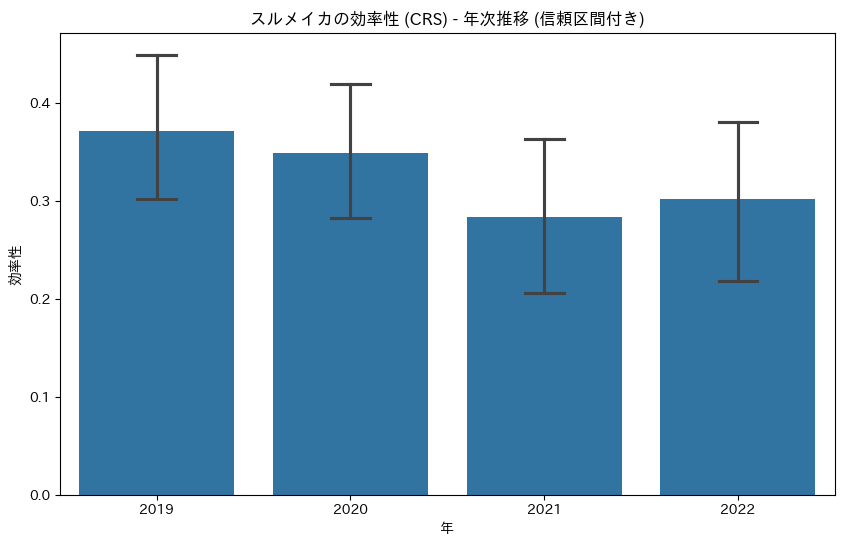

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


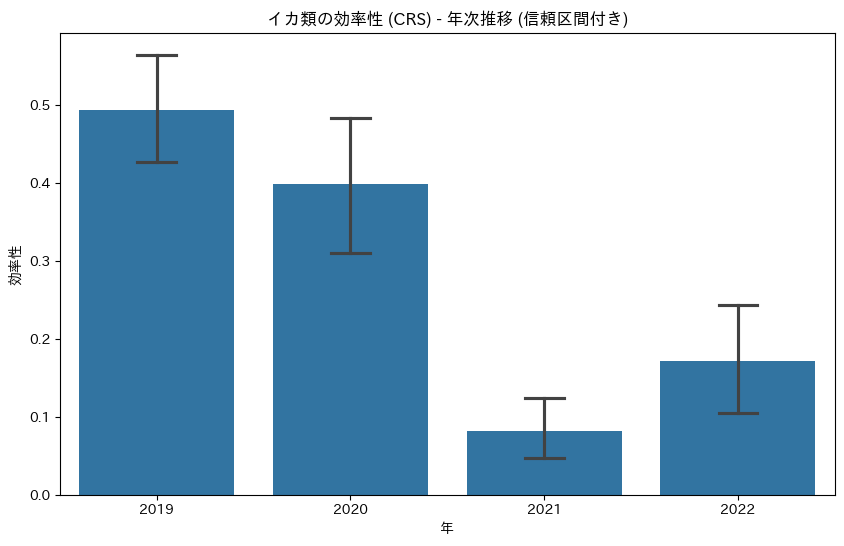

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


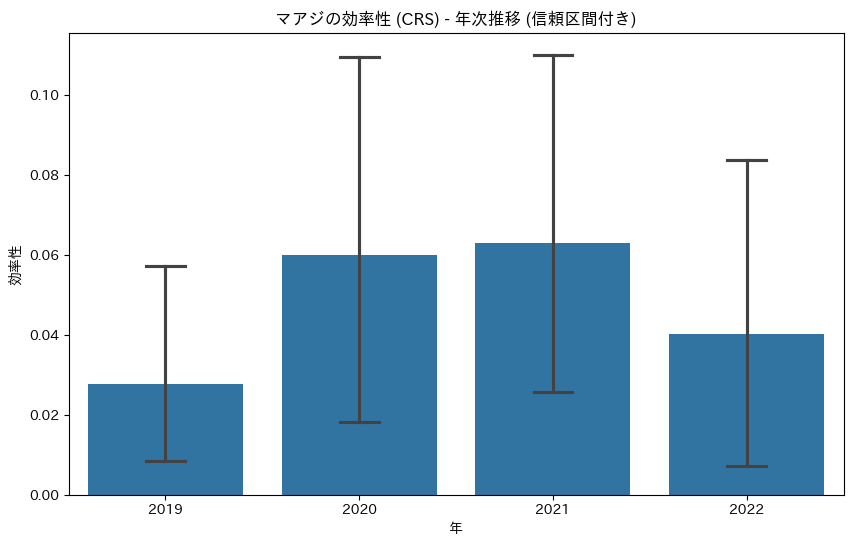

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


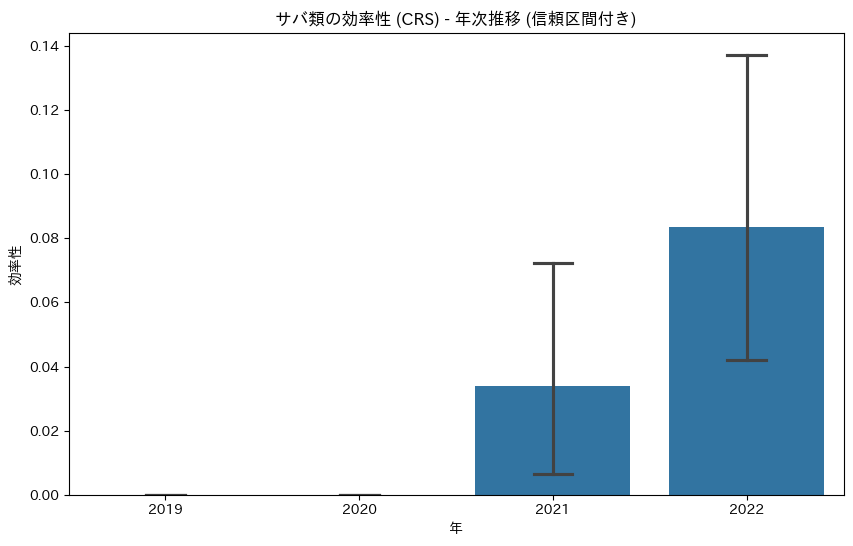

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


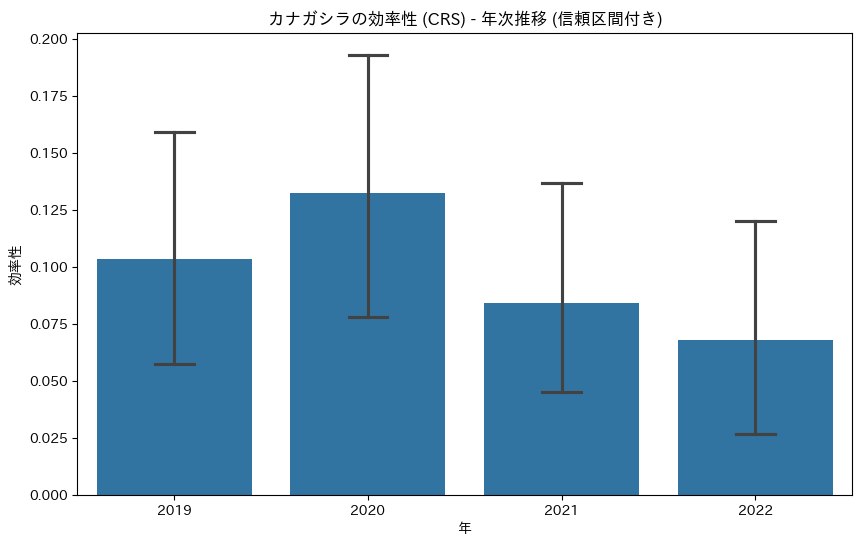

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


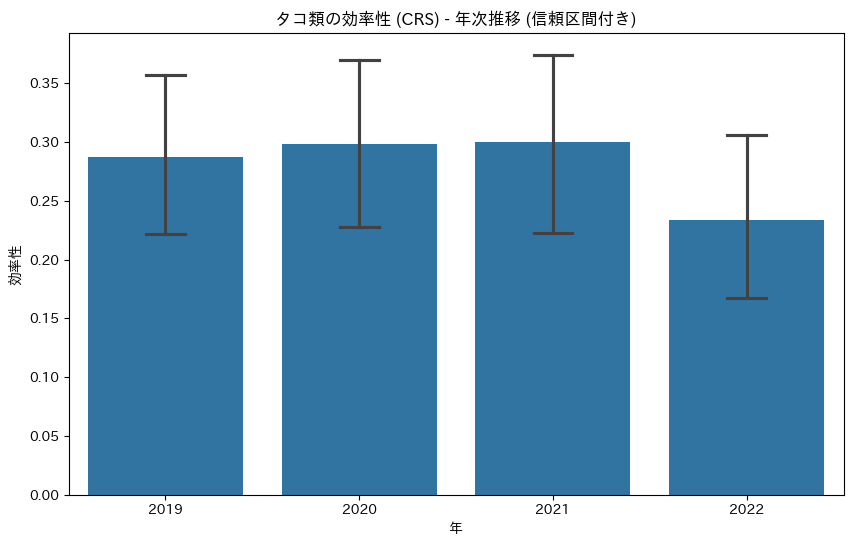

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


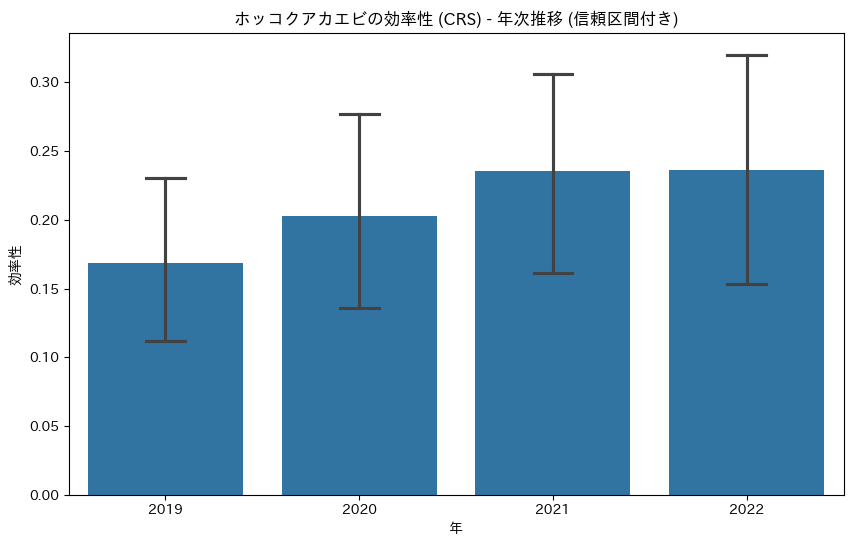

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


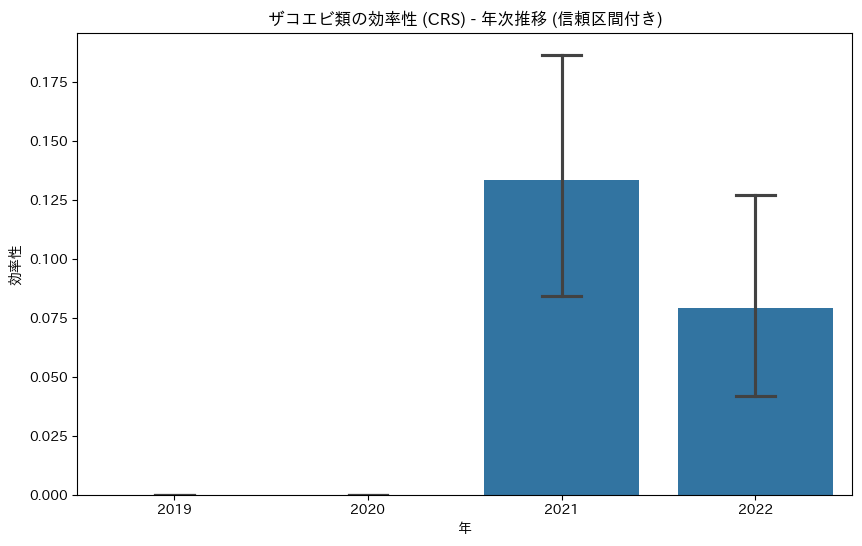

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


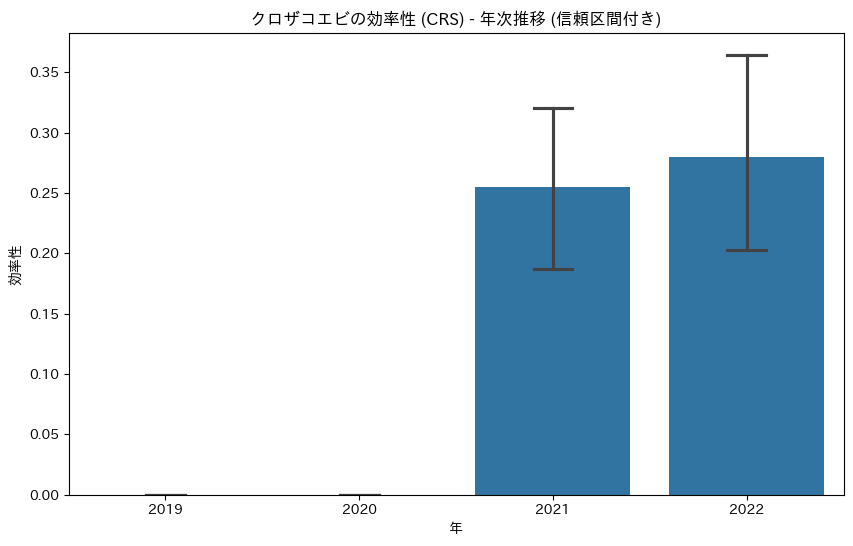

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


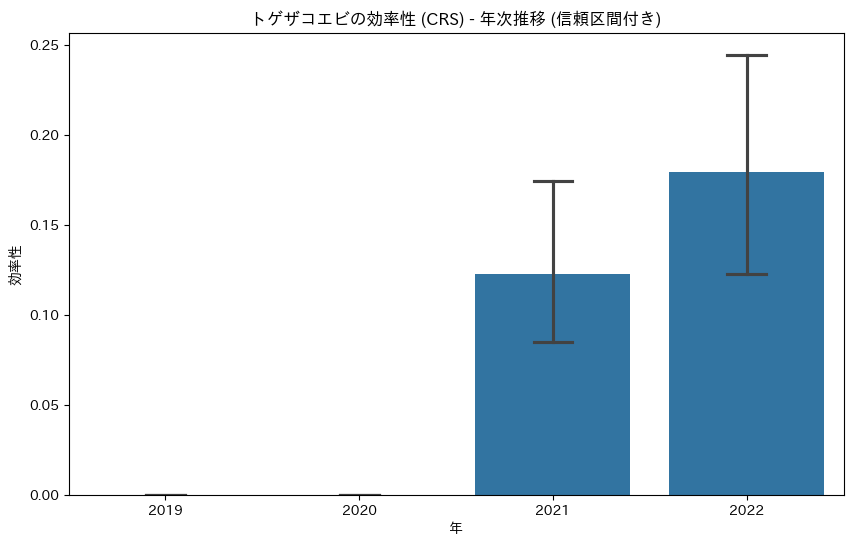

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


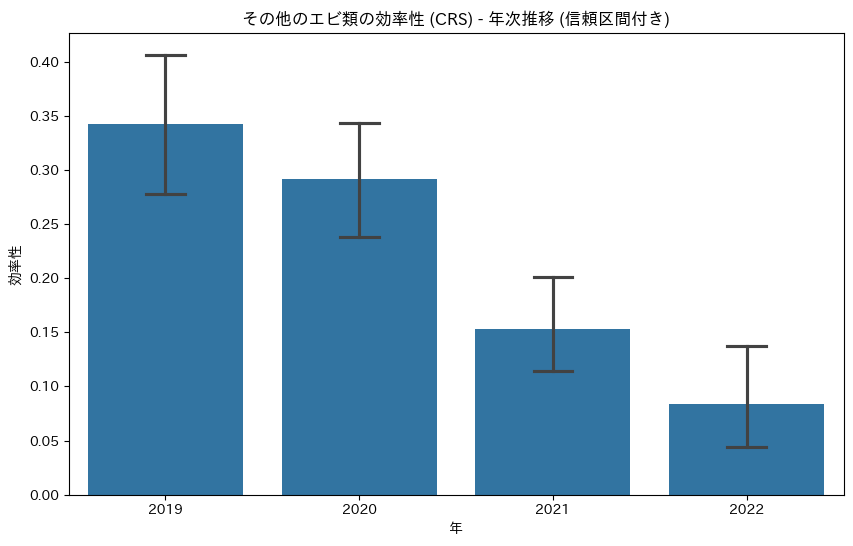

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


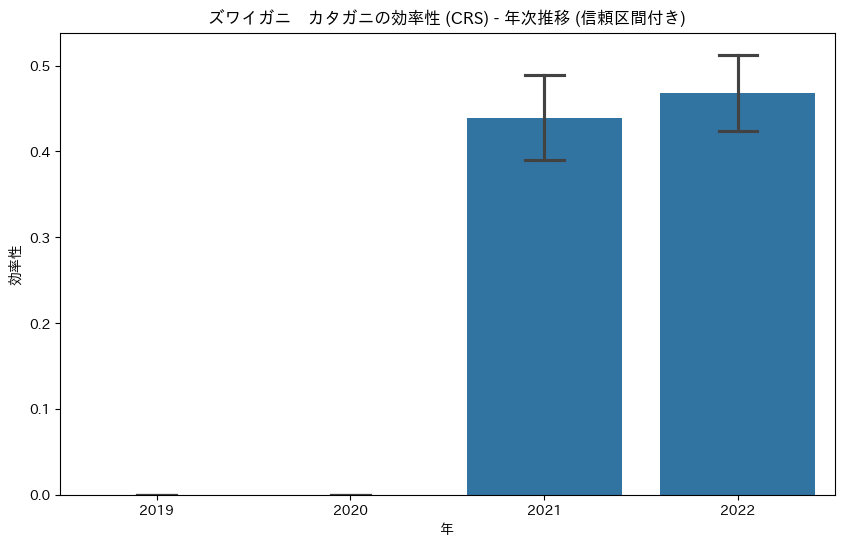

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


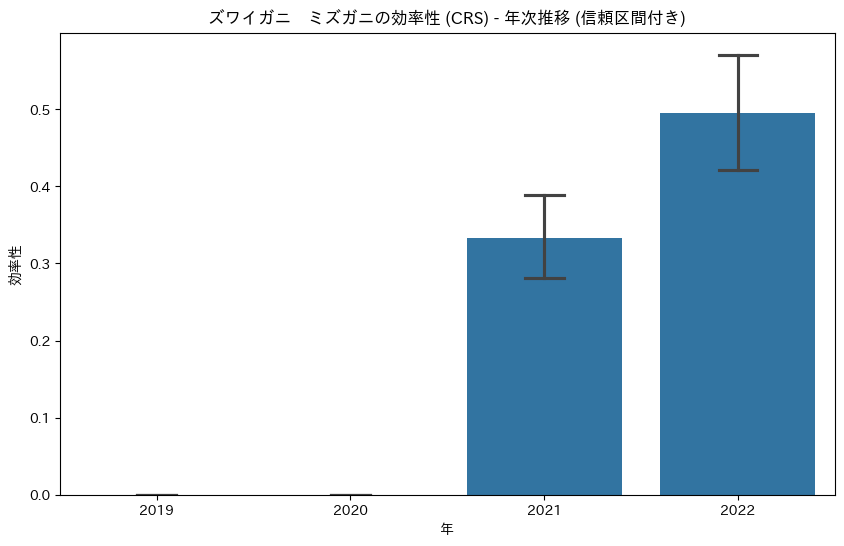

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


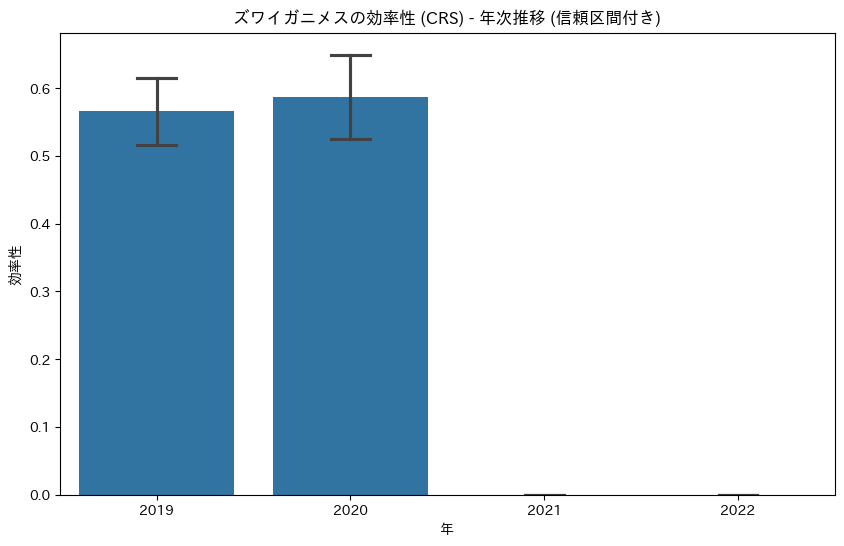

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


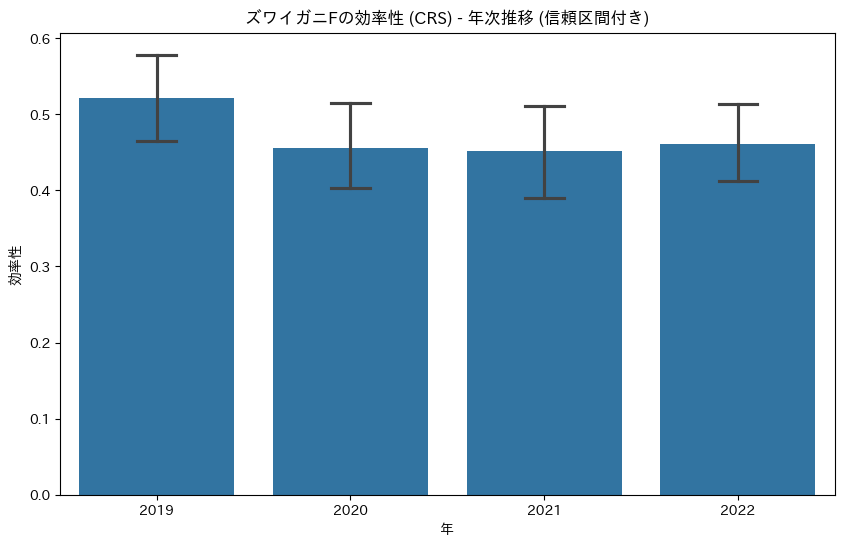

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


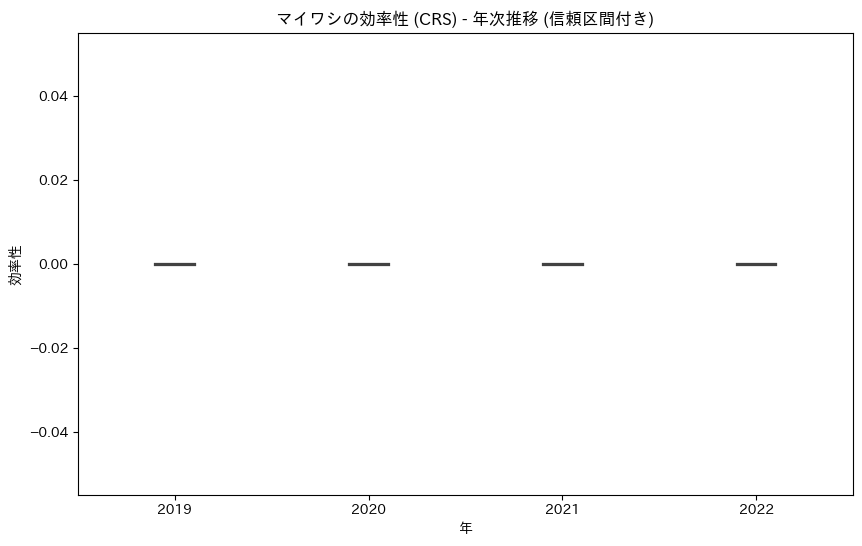

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


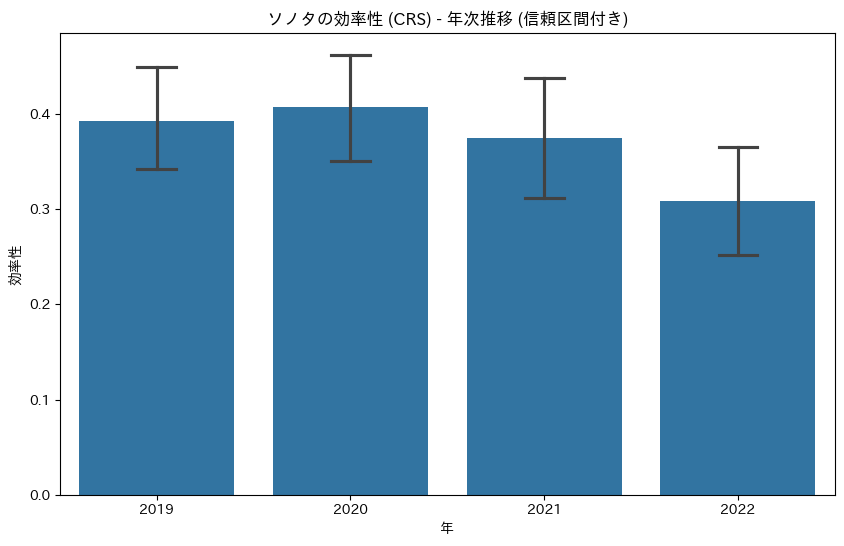

<ipython-input-9-6ad6d26b3102>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data)
<ipython-input-9-6ad6d26b3102>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)


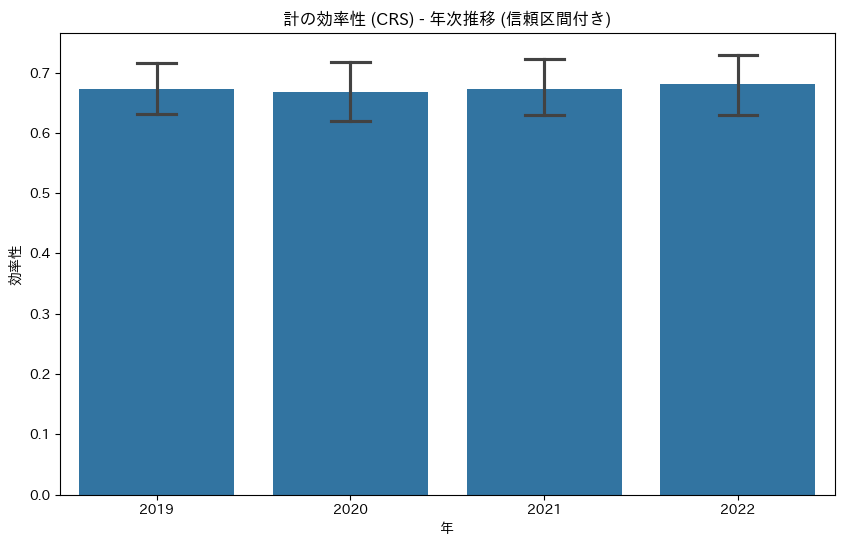

In [ ]:
# prompt: crsがついた変数をカウントが10以上ある魚種全てについて年ごとに棒グラフ（信頼区間付き）で表示

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import numpy as np

# Load the data
years = [2019, 2020, 2021, 2022, 2023]
fish_types = ['マダラ', 'スケトウダラ', 'ホッケ', 'ハタハタ', 'サメ・エイ', 'ヒラメ', 'ソウハチ', 'ヒレグロ', 'アカガレイ', 'マガレイ', 'ムシガレイ', 'ヤナギムシガレイ', 'その他のカレイ', 'キアンコウ', 'ニギス', 'エソ類', 'タチウオ', 'マダイ', 'チダイ', 'キダイ', 'アカムツ', 'ハツメ', 'ヤリイカ', 'ホタルイカ', 'スルメイカ', 'イカ類', 'マアジ', 'サバ類', 'カナガシラ', 'タコ類', 'ホッコクアカエビ', 'ザコエビ類', 'クロザコエビ', 'トゲザコエビ', 'その他のエビ類', 'ズワイガニ　カタガニ', 'ズワイガニ　ミズガニ', 'ズワイガニメス', 'ズワイガニF', 'マイワシ', 'ソノタ', '計']

for fish_type in fish_types:
    # Combine data for the current fish type across all years
    all_data = []
    for year in years:
        try:
            df_year = pd.read_csv(f"crs_{year}.csv")
            all_data.append(df_year)
        except FileNotFoundError:
            print(f"File not found for year {year}, fish type {fish_type}")
            continue

    if not all_data:
        continue

    combined_df = pd.concat(all_data)

    # Count occurences of fish_type
    fish_type_count = combined_df[f"crs_{fish_type}"].count()

    # Filter out fish with fewer than 10 counts
    if fish_type_count < 10:
        continue

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="操業年", y=f"crs_{fish_type}", data=combined_df, ci=95, capsize=.2)
    plt.title(f"{fish_type}の効率性 (CRS) - 年次推移 (信頼区間付き)")
    plt.xlabel("年")
    plt.ylabel("効率性")

    plt.show()

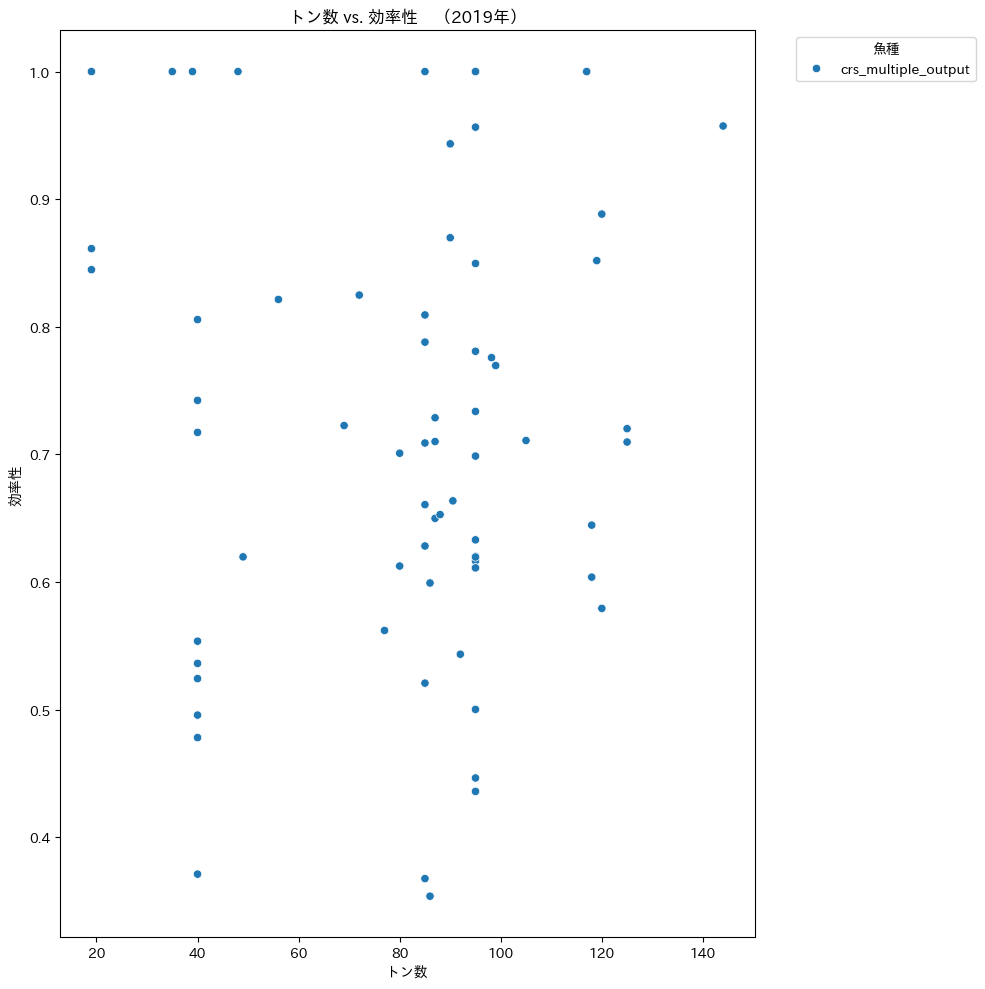

In [ ]:
df = pd.read_csv("/content/crs_2019.csv")

#! pip install japanize-matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib


# Assuming your dataframe is named 'df' and loaded with the efficiency data

# Columns for efficiency scores
eff_cols = [col for col in df.columns if col.startswith('crs_')]

# Create a long-form dataframe for plotting
df_melted = df.melt(id_vars=['トン数'], value_vars=eff_cols,
                    var_name='魚種', value_name='効率性')

# Create the scatter plot using seaborn with adjusted figure size and aspect ratio
plt.figure(figsize=(10, 10))  # Increased figure height
#plt.subplots_adjust(right=0.7)  # Adjust right margin if needed

sns.scatterplot(data=df_melted, x='トン数', y='効率性', hue='魚種')
plt.title('トン数 vs. 効率性　（2019年）')
plt.xlabel('トン数')
plt.ylabel('効率性')

# Move legend outside the plot to the right
plt.legend(title='魚種', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
import itables
itables.init_notebook_mode(all_interactive=True)
itables.show(crs_sketodara_counts.to_frame().reset_index().rename(columns={'index': 'crs_スケトウダラ', 'crs_スケトウダラ': 'Count'}))

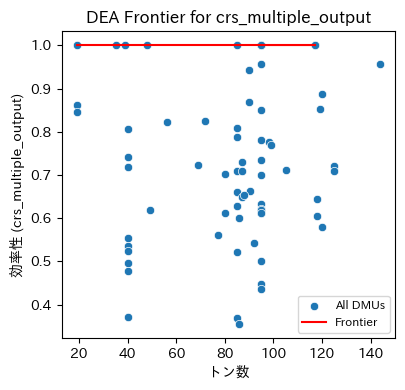

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# Assuming your dataframe is named 'df' and loaded with the efficiency data

# Columns for efficiency scores
eff_cols = [col for col in df.columns if col.startswith('crs_')]

# Calculate grid dimensions
num_cols = 4  # Number of columns in the grid
num_rows = int(len(eff_cols) / num_cols) + (len(eff_cols) % num_cols > 0)  # Calculate number of rows

# Create subplots with smaller size and grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through fish types and plot frontiers
for i, fish_type in enumerate(eff_cols):
    # Filter for efficient DMUs for the current fish type
    efficient_df = df[df[fish_type] == 1]

    # Plot on the corresponding subplot
    sns.scatterplot(data=df, x='トン数', y=fish_type, label='All DMUs', ax=axes[i])
    sns.lineplot(data=efficient_df, x='トン数', y=fish_type, color='red', label='Frontier', ax=axes[i])
    axes[i].set_title(f'DEA Frontier for {fish_type}')
    axes[i].set_xlabel('トン数')
    axes[i].set_ylabel(f'効率性 ({fish_type})')
    axes[i].legend(fontsize='small')  # Reduce legend font size

# Hide any extra subplots if the number of fish types is not a multiple of num_cols
for j in range(len(eff_cols), num_rows * num_cols):
    axes[j].set_visible(False)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

<ipython-input-31-f95d87f6dc86>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='魚種')


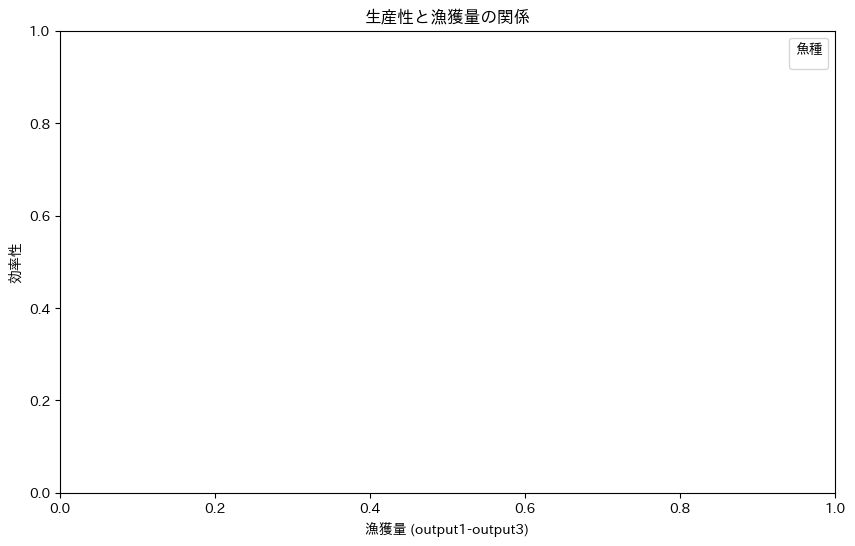

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# Assuming your dataframe is named 'df' and loaded with the efficiency data

# Columns for efficiency scores (productivity)
eff_cols = [col for col in df.columns if col.startswith('eff_')]

# Columns for catch volume (漁獲量)
catch_cols = ['output1', 'output2', 'output3']

# Create a long-form dataframe for plotting
df_melted = df.melt(id_vars=catch_cols, value_vars=eff_cols,
                    var_name='魚種', value_name='効率性')


# Calculate total catch volume for each row
df_melted['TotalCatch'] = df_melted[catch_cols].sum(axis=1)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x='TotalCatch', y='効率性', hue='魚種')
plt.title('生産性と漁獲量の関係')
plt.xlabel('漁獲量 (output1-output3)')
plt.ylabel('効率性')
plt.legend(title='魚種')
plt.show()

<ipython-input-32-4455df62d241>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside


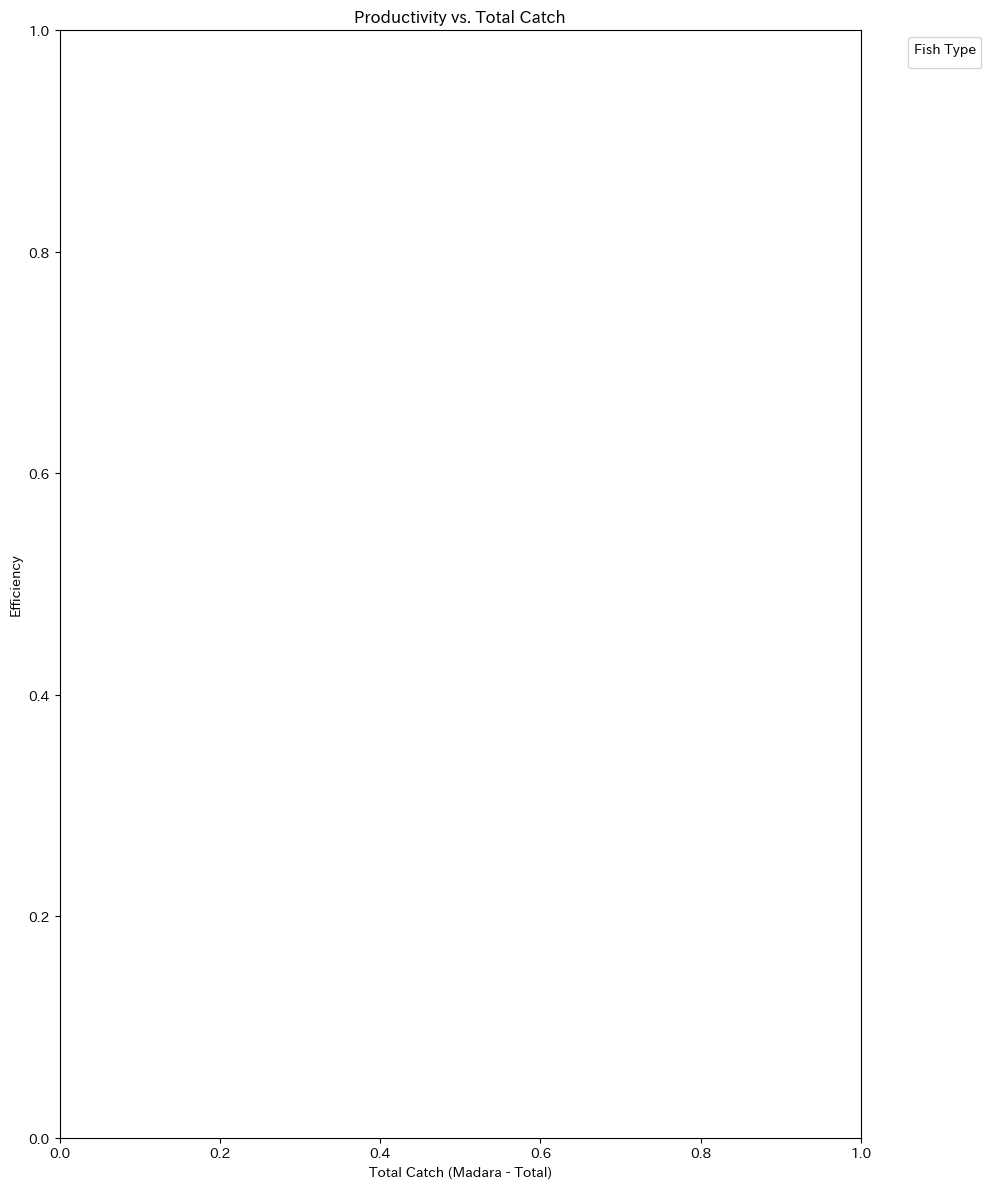

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import japanize_matplotlib #No need for it if you are not going to plot with japanese characters

# ... (Your previous code for defining eff_cols and catch_cols) ...

# Create a long-form dataframe for plotting
df_melted = df.melt(id_vars=catch_cols, value_vars=eff_cols,
                    var_name='FishType', value_name='Efficiency')

# Calculate total catch volume for each row
df_melted['TotalCatch'] = df_melted[catch_cols].sum(axis=1)

# Create the scatter plot with adjusted figure size
plt.figure(figsize=(10, 12))  # Increase the figure height here
sns.scatterplot(data=df_melted, x='TotalCatch', y='Efficiency', hue='FishType')
plt.title('Productivity vs. Total Catch')
plt.xlabel('Total Catch (Madara - Total)')
plt.ylabel('Efficiency')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
#漁績2019～2023を読み込み、年次データに変換し、DEA（VRS)を実行し、各年ごとの各魚種効率性ファイルを保存する
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

# データの読み込み, try encoding with shift-jis
df = pd.read_csv("/content/gyoseki_py.csv", encoding='shift-jis')

# IDでCollapseする
columns_to_fill = ['マダラ', 'スケトウダラ', 'ホッケ', 'ハタハタ', 'サメ・エイ', 'ヒラメ', 'ソウハチ', 'ヒレグロ', 'アカガレイ', 'マガレイ', 'ムシガレイ', 'ヤナギムシガレイ', 'その他のカレイ', 'キアンコウ', 'ニギス', 'エソ類', 'タチウオ', 'マダイ', 'チダイ', 'キダイ', 'アカムツ', 'ハツメ', 'ヤリイカ', 'ホタルイカ', 'スルメイカ', 'イカ類', 'マアジ', 'サバ類', 'カナガシラ', 'タコ類', 'ホッコクアカエビ', 'ザコエビ類', 'クロザコエビ', 'トゲザコエビ', 'その他のエビ類', 'ズワイガニ　カタガニ', 'ズワイガニ　ミズガニ', 'ズワイガニメス', 'ズワイガニF', 'マイワシ', 'ソノタ', '計']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

years = [2019, 2020, 2021, 2022, 2023]

# Iterate through years
for year in years:
    # Filter dataframe for the specific year
    df_year = df[df['操業年'] == year]

    # Group by ID and year
    grouped = df_year.groupby(['ID', '操業年'])
    collapsed = grouped.agg({
        **{col: 'sum' for col in df.loc[:, '網数':'計'].columns},
        "都道府県": 'first',
        "漁法コード": 'first',
        '馬力': 'mean',
        'トン数': 'mean',
        "通常従業員数": 'mean'
    })

    # Reorder columns
    net_to_total_cols = collapsed.loc[:, '網数':'計'].columns.tolist()
    order = ["都道府県", "漁法コード", "馬力", "トン数", "通常従業員数"] + net_to_total_cols
    collapsed = collapsed[order]

    # Fill NaN values
    collapsed['馬力'] = collapsed.groupby('ID')['馬力'].transform(lambda x: x.fillna(x.mean()))
    collapsed['トン数'] = collapsed.groupby('ID')['トン数'].transform(lambda x: x.fillna(x.mean()))
    collapsed['通常従業員数'] = collapsed.groupby('ID')['通常従業員数'].transform(lambda x: x.fillna(x.mean()))

    # Reset index
    collapsed = collapsed.reset_index()
    collapsed = collapsed.dropna()

    # Loop through fish types and calculate efficiency
    for fish_type in columns_to_fill:
        dea = EnvelopDEA("VRS", "in")
        dea.fit(
            collapsed[["馬力", "トン数", "網数", "通常従業員数"]].to_numpy(),
            collapsed[[fish_type]].to_numpy(),
        )
        result = dea.results

        # Add efficiency to the dataframe
        efficiency_df = pd.DataFrame(result, columns=["score"], index=collapsed.index)
        collapsed = pd.merge(collapsed, efficiency_df, left_index=True, right_index=True)
        collapsed = collapsed.rename(columns={"score": f"vrs_{fish_type}"})

    # Save the results for the current year
    collapsed.to_csv(f"vrs_{year}.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gyoseki_py.csv'

In [ ]:
df.head()

,ID,操業年,都道府県,漁法コード,馬力,トン数,通常従業員数,網数,マダラ,スケトウダラ,...,crs_クロザコエビ,crs_トゲザコエビ,crs_その他のエビ類,crs_ズワイガニ カタガニ,crs_ズワイガニ ミズガニ,crs_ズワイガニメス,crs_ズワイガニF,crs_マイワシ,crs_ソノタ,crs_計
0,2,2019,鳥取県,1,661.000000,119.000000,9.770000,1698,20794.0,0.0,...,0.0,0.0,0.478053,0.0,0.0,0.716115,1.000000,0.0,0.784813,0.824049
1,3,2019,兵庫県,1,637.084084,92.957958,8.630631,2836,12096.0,0.0,...,0.0,0.0,0.640691,0.0,0.0,0.806424,1.000000,0.0,0.886620,1.000000
2,5,2019,鳥取県,1,588.000000,85.000000,10.000000,1523,10328.0,0.0,...,0.0,0.0,1.000000,0.0,0.0,0.780021,0.884209,0.0,0.682971,0.762190
3,6,2019,鳥取県,1,956.000000,117.000000,10.000000,1668,50071.0,0.0,...,0.0,0.0,0.211201,0.0,0.0,0.886115,0.857912,0.0,0.293497,0.882739
4,7,2019,兵庫県,1,617.000000,85.000000,8.000000,1142,2630.0,0.0,...,0.0,0.0,0.110642,0.0,0.0,0.395140,0.227336,0.0,0.233908,0.432898


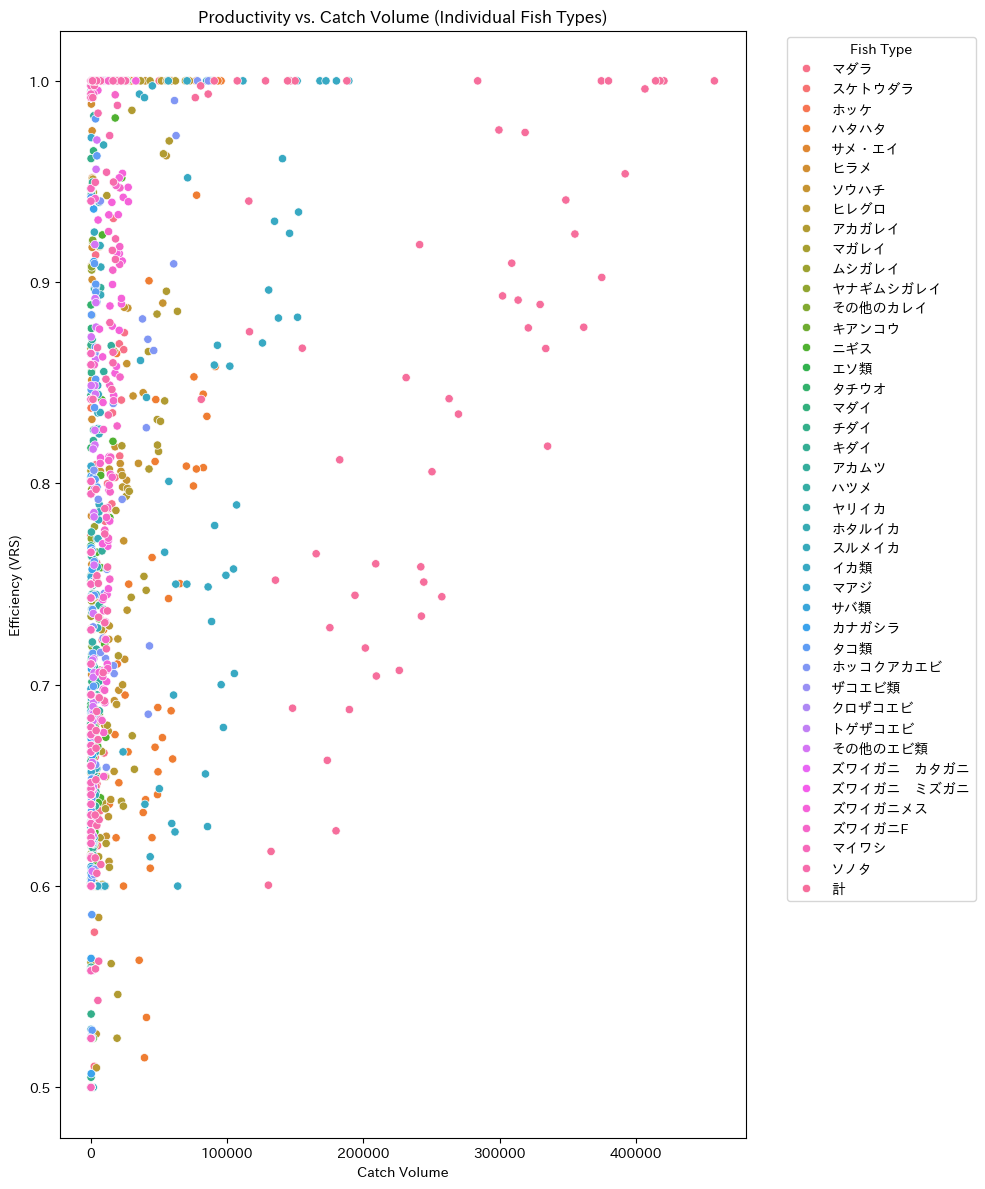

In [ ]:
df = pd.read_csv("/content/vrs_2019.csv")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your original dataframe with efficiency and catch columns

# Columns for efficiency scores (productivity)
eff_cols = [col for col in df.columns if col.startswith('vrs_')]

# Columns for catch volume (漁獲量)
catch_cols = ['マダラ', 'スケトウダラ', 'ホッケ', 'ハタハタ', 'サメ・エイ', 'ヒラメ', 'ソウハチ', 'ヒレグロ', 'アカガレイ', 'マガレイ', 'ムシガレイ', 'ヤナギムシガレイ', 'その他のカレイ', 'キアンコウ', 'ニギス', 'エソ類', 'タチウオ', 'マダイ', 'チダイ', 'キダイ', 'アカムツ', 'ハツメ', 'ヤリイカ', 'ホタルイカ', 'スルメイカ', 'イカ類', 'マアジ', 'サバ類', 'カナガシラ', 'タコ類', 'ホッコクアカエビ', 'ザコエビ類', 'クロザコエビ', 'トゲザコエビ', 'その他のエビ類', 'ズワイガニ　カタガニ', 'ズワイガニ　ミズガニ', 'ズワイガニメス', 'ズワイガニF', 'マイワシ', 'ソノタ', '計']

# Create a list to store data for plotting
plot_data = []

# Iterate through fish types and extract efficiency and catch data
for eff_col in eff_cols:
    fish_type = eff_col.replace('vrs_', '')  # Extract fish type from column name
    catch_col = fish_type if fish_type in catch_cols else None  # Find corresponding catch column

    if catch_col:
        # Append data for the current fish type to plot_data
        plot_data.extend([{'FishType': fish_type, 'Efficiency': eff, 'Catch': catch}
                          for eff, catch in zip(df[eff_col], df[catch_col])])

# Create a dataframe from plot_data
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 12))
sns.scatterplot(data=plot_df, x='Catch', y='Efficiency', hue='FishType')
plt.title('Productivity vs. Catch Volume (Individual Fish Types)')
plt.xlabel('Catch Volume')
plt.ylabel('Efficiency (VRS)')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

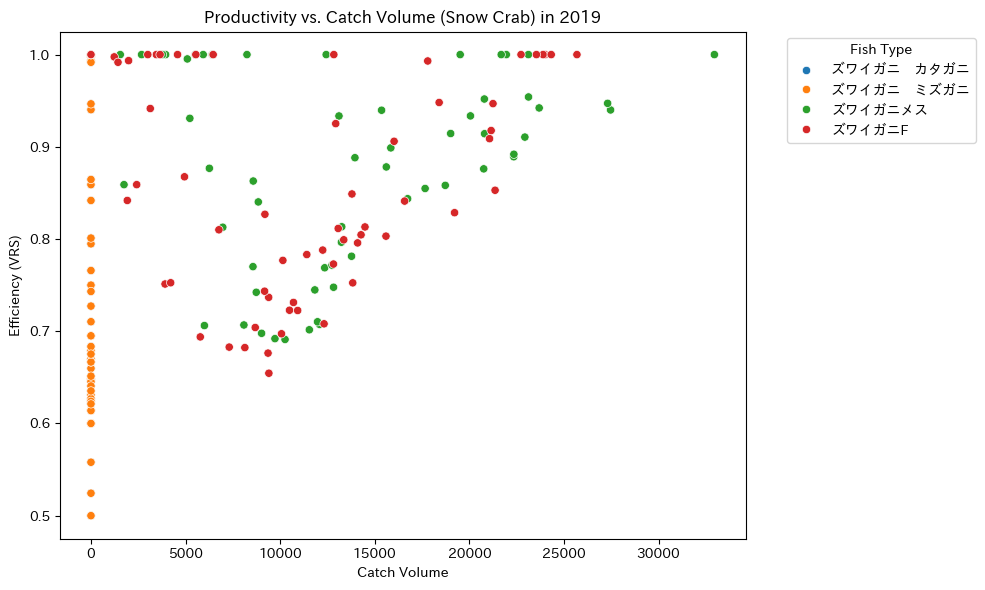

In [ ]:
df = pd.read_csv("/content/vrs_2019.csv")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your original dataframe with efficiency and catch columns

# Zuwaigani types
zuwaigani_types = ['ズワイガニ\u3000カタガニ', 'ズワイガニ\u3000ミズガニ', 'ズワイガニメス', 'ズワイガニF']

# Columns for efficiency scores (productivity)
eff_cols = [f"vrs_{fish_type}" for fish_type in zuwaigani_types]

# Columns for catch volume (漁獲量) - should match zuwaigani_types
catch_cols = zuwaigani_types

# Create a list to store data for plotting
plot_data = []

# Iterate through Zuwaigani types and extract efficiency and catch data
for eff_col, catch_col in zip(eff_cols, catch_cols):
    fish_type = eff_col.replace('vrs_', '')  # Extract fish type from column name

    # Append data for the current fish type to plot_data
    plot_data.extend([{'FishType': fish_type, 'Efficiency': eff, 'Catch': catch}
                      for eff, catch in zip(df[eff_col], df[catch_col])])

# Create a dataframe from plot_data
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='Catch', y='Efficiency', hue='FishType')
plt.title('Productivity vs. Catch Volume (Snow Crab) in 2019')
plt.xlabel('Catch Volume')
plt.ylabel('Efficiency (VRS)')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

!pip install numpy scipy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

# Assuming df is your original dataframe with efficiency and catch columns

# Zuwaigani types
zuwaigani_types = ['ズワイガニ\u3000カタガニ', 'ズワイガニ\u3000ミズガニ', 'ズワイガニメス', 'ズワイガニF']

# Columns for efficiency scores (productivity)
eff_cols = [f"vrs_{fish_type}" for fish_type in zuwaigani_types]

# Columns for catch volume (漁獲量) - should match zuwaigani_types
catch_cols = zuwaigani_types

# Create a list to store data for plotting
plot_data = []

# Iterate through Zuwaigani types and extract efficiency and catch data
for eff_col, catch_col in zip(eff_cols, catch_cols):
    fish_type = eff_col.replace('vrs_', '')  # Extract fish type from column name

    # Append data for the current fish type to plot_data
    plot_data.extend([{'FishType': fish_type, 'Efficiency': eff, 'Catch': catch}
                      for eff, catch in zip(df[eff_col], df[catch_col])])

# Create a dataframe from plot_data
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='Catch', y='Efficiency', hue='FishType')
plt.title('Productivity vs. Catch Volume (Snow Crab) in 2019')
plt.xlabel('Catch Volume')
plt.ylabel('Efficiency (VRS)')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add non-linear trend line for each fish type
for fish_type in zuwaigani_types:
    # Filter data for the current fish type
    fish_data = plot_df[plot_df['FishType'] == fish_type]

    # Sort data by Catch for spline interpolation
    fish_data = fish_data.sort_values(by=['Catch'])

    # Create spline interpolation
    x = fish_data['Catch'].to_numpy()
    y = fish_data['Efficiency'].to_numpy()
    xnew = np.linspace(x.min(), x.max(), 300)  # 300 represents number of points to make
    spl = make_interp_spline(x, y, k=3)  # k=3 represents cubic spline
    y_smooth = spl(xnew)

    # Plot the smooth line
    plt.plot(xnew, y_smooth, label=f'{fish_type} Trend') # You can remove the label if you don't want the lines labeled

plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

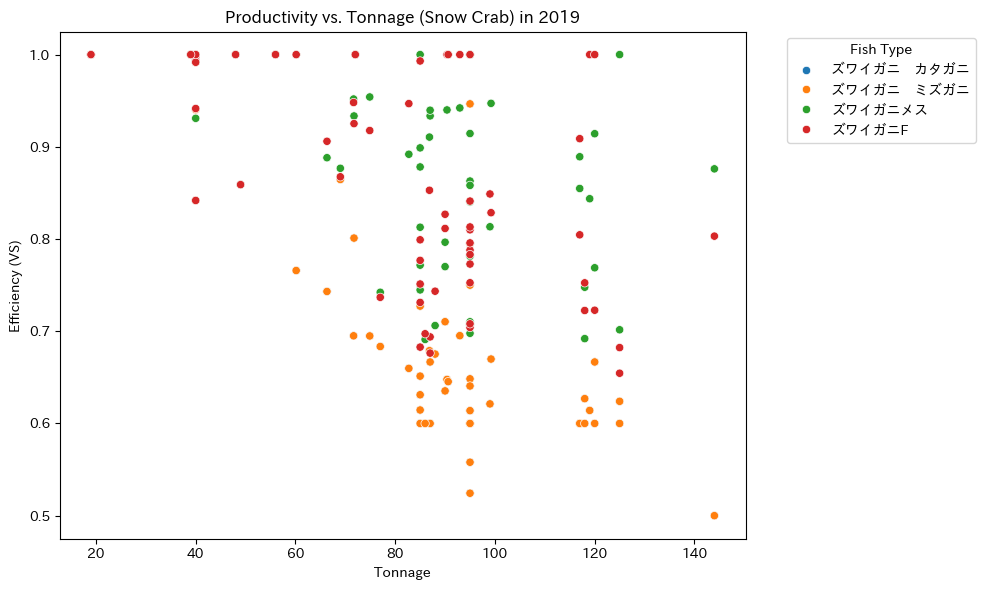

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your original dataframe with efficiency, catch, and tonnage columns

# Zuwaigani types
zuwaigani_types = ['ズワイガニ\u3000カタガニ', 'ズワイガニ\u3000ミズガニ', 'ズワイガニメス', 'ズワイガニF']

# Columns for efficiency scores (productivity)
eff_cols = [f"vrs_{fish_type}" for fish_type in zuwaigani_types]

# Create a list to store data for plotting
plot_data = []

# Iterate through Zuwaigani types and extract efficiency and tonnage data
for eff_col, fish_type in zip(eff_cols, zuwaigani_types):
    # Append data for the current fish type to plot_data
    plot_data.extend([{'FishType': fish_type, 'Efficiency': eff, 'Tonnage': tonnage}
                      for eff, tonnage in zip(df[eff_col], df['トン数'])])  # Use df['トン数'] for tonnage

# Create a dataframe from plot_data
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot with adjusted figure size
plt.figure(figsize=(10, 6))  # Decreased the height to 6
sns.scatterplot(data=plot_df, x='Tonnage', y='Efficiency', hue='FishType')  # Use 'Tonnage' for x-axis
plt.title('Productivity vs. Tonnage (Snow Crab) in 2019')
plt.xlabel('Tonnage')  # Update x-axis label
plt.ylabel('Efficiency (VS)')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

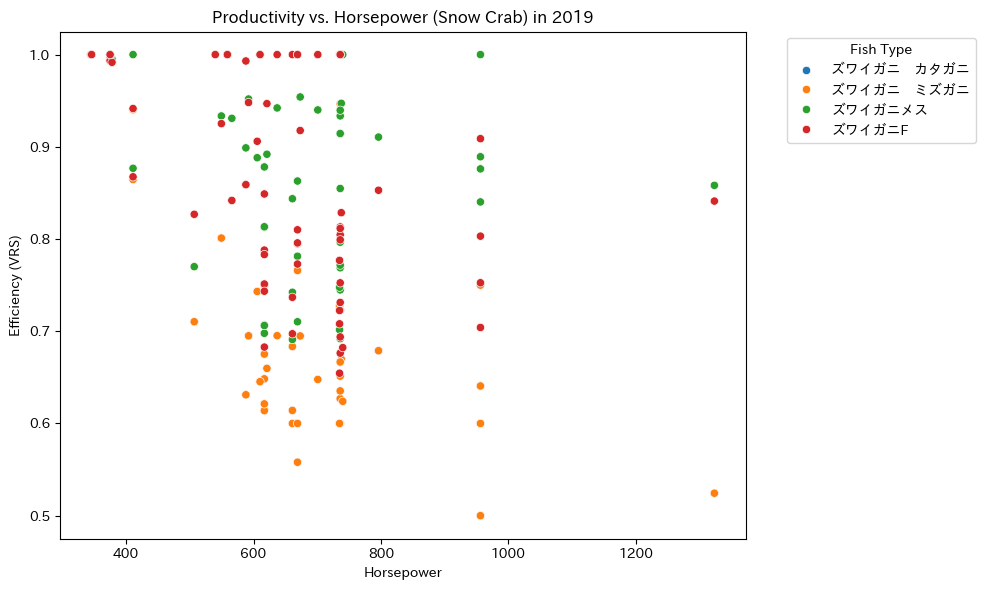

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your original dataframe with efficiency, catch, tonnage, and horsepower columns

# Zuwaigani types
zuwaigani_types = ['ズワイガニ\u3000カタガニ', 'ズワイガニ\u3000ミズガニ', 'ズワイガニメス', 'ズワイガニF']

# Columns for efficiency scores (productivity)
eff_cols = [f"vrs_{fish_type}" for fish_type in zuwaigani_types]

# Create a list to store data for plotting
plot_data = []

# Iterate through Zuwaigani types and extract efficiency and horsepower data
for eff_col, fish_type in zip(eff_cols, zuwaigani_types):
    # Append data for the current fish type to plot_data
    plot_data.extend([{'FishType': fish_type, 'Efficiency': eff, 'Horsepower': horsepower}
                      for eff, horsepower in zip(df[eff_col], df['馬力'])])  # Use df['馬力'] for horsepower

# Create a dataframe from plot_data
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot with adjusted figure size
plt.figure(figsize=(10, 6))  # Decreased the height to 6
sns.scatterplot(data=plot_df, x='Horsepower', y='Efficiency', hue='FishType')  # Use 'Horsepower' for x-axis
plt.title('Productivity vs. Horsepower (Snow Crab) in 2019')
plt.xlabel('Horsepower')  # Update x-axis label
plt.ylabel('Efficiency (VRS)')
plt.legend(title='Fish Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()